In [ ]:
#pip install prophet

In [ ]:
#pip install pathos

Import packages 

In [1]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))
import pandas as pd

from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

Import at set the config file to a config dict

In [2]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/emea/June 2024 Update/config ups emea.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]


05.22.2024


## Query the data

query data

In [3]:
daily_df = GetBQData(training_query, _input, _output) # import data from BQ

df = daily_df.copy() # create a copy
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index() # group data by date and breakdowns to remove potential duplicate ds

df.ds = pd.to_datetime(df.ds) # ensure ds is date_time type

df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)] # remove any nan or inf values 

df = df[df.ds < cutoff_month] # ensure data is only up to cutoff_point

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


Combine the small markets data into one split and the non brand funnel into one split

In [4]:
small_market_str = 'SaudiArabia|UAE|Turkey|Ireland|Sweden|Netherlands|Belgium|Czech|Spain'#
updated_df = Combine(df, 'L', small_market_str)
updated_df.market.unique()

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_countries_ori.loc[large_countries_ori[large_countries_ori['funnel'] == 'Generic'].index, 'generic_cost'] = large_countries_ori.loc[large_countries_ori['funnel'] == 'Generic', 'X']
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_countries_ori.loc[large_countries_ori[large_countries_ori['funnel'

array(['SM', 'France', 'Germany', 'Italy', 'Poland', 'UK', 'India'],
      dtype=object)

In [5]:
updated_df

,ds,region,market,account_type,funnel,Identifier,X,y,revenue,new_funnel,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend
0,2017-08-10,Europe,SM,-,-,S,1356.930006,228.0,5158.681603,BrandNon_BrandBrandBrandNon_BrandBrandNon_Bran...,NaN,NaN,0.500000,0.500000,0
1,2017-08-10,Europe,France,-,Brand,L,173.279994,173.0,7054.282462,NaN,0.000000,0.00,0.500000,0.500000,0
2,2017-08-10,Europe,France,-,Non_Brand,L,1159.840001,3.0,122.328598,NaN,1159.840001,0.00,1.000000,0.000000,0
3,2017-08-10,Europe,Germany,-,Brand,L,503.510001,654.0,10945.736186,NaN,0.000000,0.00,0.500000,0.500000,0
4,2017-08-10,Europe,Germany,-,Non_Brand,L,541.579995,14.0,283.717798,NaN,541.579995,0.00,1.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31832,2024-04-23,Europe,Poland,-,Non_Brand,L,210.370000,57.0,1177.329977,NaN,4.570000,205.80,0.021724,0.978276,0
31833,2024-04-23,Europe,UK,-,Brand,L,5927.946900,1057.0,24446.075943,NaN,0.000000,0.00,0.500000,0.500000,0
31834,2024-04-23,Europe,UK,-,Non_Brand,L,50.350000,17.0,272.891697,NaN,34.310000,16.04,0.681430,0.318570,0
31835,2024-04-23,Europe,India,-,Brand,L,441.527800,193.0,16368.877419,NaN,0.000000,0.00,0.500000,0.500000,0


Drop outliers 

In [6]:
# Germany Non_Brand 2022 previous data 
updated_df.drop(updated_df[(updated_df.market == 'Germany') & (updated_df.funnel == 'Non_Brand') & (updated_df.ds <'2022-01-01')].index, inplace=True)

# France Non_Brand 2020-06 previous data 
updated_df.drop(updated_df[(updated_df.market == 'France') & (updated_df.funnel == 'Non_Brand') & (updated_df.ds <'2020-06-01')].index, inplace=True)


Add regresors 

In [7]:

# anomaly data in august-october 2021
updated_df['anomaly_2021'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2021,8,1))\
                                     & (x <= datetime.datetime(2021,10,31)) else 0)

# Covid year(2020)
updated_df['covid_year_dummy'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2020,1,1))\
                                     & (x <= datetime.datetime(2020,12,31)) else 0)

# weekends seasonality
updated_df['weekday_or_weekend'] = updated_df['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# nov to Dec 2018
updated_df['nov_dec_2018'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2018,11,1))\
                                     & (x <= datetime.datetime(2018,12,31)) else 0)

# Jul to Dec 2019
updated_df['jul_dec_2019'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2019,7,1))\
                                     & (x <= datetime.datetime(2019,12,31)) else 0)

# March 2018
updated_df['mar_2018'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2018,3,1))\
                                     & (x <= datetime.datetime(2018,3,31)) else 0)

# april 2019
updated_df['apr_2019'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2019,4,1))\
                                     & (x <= datetime.datetime(2019,4,30)) else 0)

# may 2019
updated_df['may_2019'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2019,5,1))\
                                     & (x <= datetime.datetime(2019,5,31)) else 0)

# dec 2022
updated_df['dec_2022'] = updated_df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2022,12,1))\
                                     & (x <= datetime.datetime(2022,12,31)) else 0)

#covid_year_exclude


# Model constraint file 
    Upload model constraint file, which has for each split (account_type & funnel) the AOV and ROAS

In [8]:
boundary_df = pd.read_csv(boundary_df_in_path)
boundary_df.rename(columns = {'Market': 'market', 'Funnel':'funnel'}, inplace = True)
boundary_df


,market,Account Type,funnel,AOV,ROAS
0,US General,Bing Ads,Brand,34.95,35.66
1,US General,Bing Ads,Competitor,33.09,23.96
2,US General,Bing Ads,Generic,36.63,6.25
3,US General,Google AdWords,Brand,34.54,22.33
4,US General,Google AdWords,Competitor,32.36,33.84
5,US General,Google AdWords,Generic,43.94,5.99
6,France,-,Brand,35.97,7.83
7,France,-,Non_Brand,31.04,5.57
8,Germany,-,Brand,24.69,8.13
9,Germany,-,Non_Brand,27.63,6.91


In [9]:
boundary_df.loc[boundary_df['market'].isin(['Spain','India'])]

,market,Account Type,funnel,AOV,ROAS
21,India,-,Brand,98.55,24.80
22,India,-,Non_Brand,128.19,19.40
23,Spain,-,Brand,31.47,7.81
24,Spain,-,Non_Brand,27.29,8.75


filter the data in df to just the one that is going to be used (only the ones with splits from the boundary_df) <br>
this is set with an inner merge of boundary_df and df. 

In [10]:
updated_df = pd.merge(updated_df, boundary_df, on = ['market', 'funnel'])


add additional variables needed but that are not regressors in the prophet model 

In [11]:
updated_df.market.unique()

array(['SM', 'France', 'Germany', 'Italy', 'Poland', 'UK', 'India'],
      dtype=object)

In [12]:

# create  a variable that indicates the month of the date in words 
updated_df['Month of Ds'] = updated_df['ds'].dt.month_name()

# set floor to the model forecast -> the model should not predict values below this value 
updated_df['floor'] = 0

# set cap to the mnodel forecast -> max values, where the model should not forecast above this values 
updated_df['cap'] = updated_df.ROAS * updated_df.X / updated_df.AOV
updated_df = updated_df.fillna(0)
updated_df.loc[round(updated_df.cap,0) == 0, 'cap'] = updated_df.cap.mean()

updated_df.tail()

,ds,region,market,account_type,funnel,Identifier,X,y,revenue,new_funnel,...,mar_2018,apr_2019,may_2019,dec_2022,Account Type,AOV,ROAS,Month of Ds,floor,cap
29201,2024-04-23,Europe,Poland,-,Non_Brand,L,210.3700,57.0,1177.329977,0,...,0,0,0,0,-,19.20,14.67,April,0,160.735828
29202,2024-04-23,Europe,UK,-,Brand,L,5927.9469,1057.0,24446.075943,0,...,0,0,0,0,-,23.16,6.01,April,0,1538.297101
29203,2024-04-23,Europe,UK,-,Non_Brand,L,50.3500,17.0,272.891697,0,...,0,0,0,0,-,24.36,5.37,April,0,11.099323
29204,2024-04-23,Europe,India,-,Brand,L,441.5278,193.0,16368.877419,0,...,0,0,0,0,-,98.55,24.80,April,0,111.109989
29205,2024-04-23,Europe,India,-,Non_Brand,L,248.3100,62.0,5391.062054,0,...,0,0,0,0,-,128.19,19.40,April,0,37.578703


Add Covid Data

In [13]:
covid_df = GetCovidData('EU')
covid_df.loc[covid_df['market']=='United Kingdom','market'] = 'UK'
final_df = updated_df.merge(covid_df, how = 'left', on = ['ds', 'market'])
final_df = final_df.fillna(0)

final_df.to_csv(daily_df_out_path)
final_df.head()


,ds,region,market,account_type,funnel,Identifier,X,y,revenue,new_funnel,...,apr_2019,may_2019,dec_2022,Account Type,AOV,ROAS,Month of Ds,floor,cap,new_confirmed
0,2017-08-10,Europe,SM,-,-,S,1356.930006,228.0,5158.681603,BrandNon_BrandBrandBrandNon_BrandBrandNon_Bran...,...,0,0,0,-,76.01,28.37,August,0,506.461048,0
1,2017-08-10,Europe,France,-,Brand,L,173.279994,173.0,7054.282462,0,...,0,0,0,-,35.97,7.83,August,0,37.719832,0
2,2017-08-10,Europe,Germany,-,Brand,L,503.510001,654.0,10945.736186,0,...,0,0,0,-,24.69,8.13,August,0,165.797339,0
3,2017-08-10,Europe,Italy,-,Brand,L,64.960001,117.0,2945.112242,0,...,0,0,0,-,37.09,12.42,August,0,21.752580,0
4,2017-08-10,Europe,Italy,-,Non_Brand,L,510.899996,2.0,50.343799,0,...,0,0,0,-,41.72,11.79,August,0,144.379457,0


# Analytical File Generator

Generate the analytical file. <br>
    Data frame that sets the future values of X in base of the values of last years X by day <br>
    Adds variables for each split (X value for the split and 0 other wise)

In [14]:
generator = AnalyticalFileGenerator(config_dict, final_df)
analytical_file_df = generator.generate()
analytical_file_df

,ds,region,market,account_type,funnel,Identifier,X,revenue,new_funnel,generic_cost,...,UK_-_Brand_Sep_2024,UK_-_Non_Brand_Apr_2024,UK_-_Non_Brand_Aug_2024,UK_-_Non_Brand_Dec_2024,UK_-_Non_Brand_Jul_2024,UK_-_Non_Brand_Jun_2024,UK_-_Non_Brand_May_2024,UK_-_Non_Brand_Nov_2024,UK_-_Non_Brand_Oct_2024,UK_-_Non_Brand_Sep_2024
0,2024-04-25,Europe,France,-,Brand,L,3867.3200,39320.913507,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-04-25,Europe,France,-,Non_Brand,L,185.3300,1700.537720,0,139.0700,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-04-25,Europe,Germany,-,Brand,L,4192.8800,44622.107477,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-04-25,Europe,Germany,-,Non_Brand,L,472.7200,3333.379901,0,255.4900,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-04-25,Europe,India,-,Brand,L,668.5700,18969.429558,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,2024-12-31,Europe,Poland,-,Brand,L,289.4350,5319.808425,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3259,2024-12-31,Europe,Poland,-,Non_Brand,L,33.9100,344.225395,0,13.5200,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3260,2024-12-31,Europe,SM,-,-,S,3166.0965,57201.250833,BrandNon_BrandNon_BrandBrandNon_BrandNon_Brand...,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3261,2024-12-31,Europe,UK,-,Brand,L,4183.4900,16074.924459,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


#### Save analytical file

In [15]:
analytical_file_df.to_csv(analytical_file_path) # export the analytical file 
generator.SaveFile(config_dict["FILEPATH"]["analytical_file_path"], folder_name) # save analytical file into GCS bucket


Data Frame file saved
Analytical_File_EMEA.csv saved


# cuts df

import cuts_df. Initial prophet hyper parameters the ones set on previous refresh

In [16]:
cuts_df = pd.read_csv(cuts_df_in_path) # import cuts_df
cuts_df['periods'] = periods # add column that inidcates number of periods to forecast
cuts_df['periods_for_acc_cal'] = 183 #periods # add number of periods that are left out of sample to calculate the accuracy 
cuts_df['cutoff_month'] = cutoff_month # add a column that sets the cuttof day of the data set 

cuts_df = cuts_df.loc[cuts_df['market']!='Spain']
cuts_df

,market,account_type,funnel,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,include_holiday,...,generic_cost_split,competitor_cost_split,new_confirmed,Nov_Dec_2018,Jul_Dec_2019,power,growth,periods,periods_for_acc_cal,cutoff_month
0,France,-,Brand,0.05,0.01,10.00,additive,multiplicative,multiplicative,na,...,additive,multiplicative,na,na,na,na,logistic,252.0,183,2024-04-24
1,France,-,Non_Brand,0.05,0.01,0.01,multiplicative,multiplicative,na,na,...,na,additive,multiplicative,na,na,na,linear,252.0,183,2024-04-24
2,Germany,-,Brand,0.05,0.01,0.01,multiplicative,multiplicative,additive,na,...,additive,multiplicative,na,na,na,na,linear,252.0,183,2024-04-24
3,Germany,-,Non_Brand,0.50,1.00,0.01,additive,multiplicative,additive,na,...,na,na,na,na,na,na,logistic,252.0,183,2024-04-24
4,Italy,-,Brand,0.50,10.00,1.00,multiplicative,multiplicative,multiplicative,na,...,na,na,na,na,na,na,linear,252.0,183,2024-04-24
5,Italy,-,Non_Brand,0.05,0.10,10.00,multiplicative,additive,multiplicative,na,...,na,na,na,na,na,na,linear,252.0,183,2024-04-24
6,Poland,-,Brand,0.05,0.10,1.00,multiplicative,additive,multiplicative,na,...,na,na,na,na,na,na,linear,252.0,183,2024-04-24
7,Poland,-,Non_Brand,0.10,0.01,0.01,multiplicative,multiplicative,na,na,...,na,na,na,additive,additive,na,linear,252.0,183,2024-04-24
8,SM,-,-,0.50,0.10,0.10,additive,additive,additive,na,...,na,na,na,additive,additive,na,linear,252.0,183,2024-04-24
9,UK,-,Brand,0.50,0.01,10.00,additive,additive,multiplicative,na,...,na,na,na,na,na,na,logistic,252.0,183,2024-04-24


In [17]:
# create a list of variable names that make each split 
query_item_list = [query_item for query_item in [config_dict["CLIENTINFO"]["breakdown1"], \
                             config_dict["CLIENTINFO"]["breakdown2"], \
                             config_dict["CLIENTINFO"]["breakdown3"], \
                             config_dict["CLIENTINFO"]["breakdown4"]]
                             if query_item != None]

query_item_list

['market', 'account_type', 'funnel']

# Accuracy based on previous refresh

##### First check the accuracy based on previous refresh

In [39]:
calculator = AccuracyCalculator() 
accuracy_df = calculator.CalculateAccuracy(cuts_df, final_df, query_item_list) # calculate accuracy based on cuts_df previous hyper parameters
# calculator.SaveFile()

15:45:12 - cmdstanpy - INFO - Chain [1] start processing
15:45:12 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=Tr

It's overpredicted.
Monthly Error: 33.87 Period MAE: 32.129999999999995


15:45:16 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 32.46 Period MAE: 4.0


15:45:16 - cmdstanpy - INFO - Chain [1] start processing
15:45:17 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)
15:45:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 7.92 Period MAE: 2.1999999999999997


15:45:18 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 121.67 Period MAE: 115.78999999999999


15:45:19 - cmdstanpy - INFO - Chain [1] start processing
15:45:21 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 32.69 Period MAE: 31.34


15:45:22 - cmdstanpy - INFO - Chain [1] start processing
15:45:22 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 95.98 Period MAE: 95.16


15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:24 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 11.98 Period MAE: 7.86


15:45:25 - cmdstanpy - INFO - Chain [1] start processing
15:45:26 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 38.44 Period MAE: 48.39


15:45:27 - cmdstanpy - INFO - Chain [1] start processing
15:45:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.17 Period MAE: 47.68


15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 88.25 Period MAE: 85.25


15:45:32 - cmdstanpy - INFO - Chain [1] start processing
15:45:33 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 90.11 Period MAE: 25.05


15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 27.86 Period MAE: 28.000000000000004


15:45:36 - cmdstanpy - INFO - Chain [1] start processing
15:45:38 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 29.28 Period MAE: 19.75


create accuracy table for each split 

In [40]:
accuracy = accuracy_df.groupby(['market','account_type', 'funnel']).mean(numeric_only=1) # group by split 
accuracy['Accuracy'] = np.where(accuracy['MAPE'] > 100, 'MAPE above 100%', 100 - accuracy['MAPE']) # create accuracy from MAPE 
accuracy['Forecast Period Accuracy'] = np.where(accuracy['Forecast Period MAE'] > 100, 'Forecast Period MAE above 100%', 100 - accuracy['Forecast Period MAE']) # create period accuracy from period MAPE
accuracy.drop(columns=['MAPE','Forecast Period MAE'], inplace=True) # drop error columns 
accuracy.rename(columns = {'Percentage Error': 'Mean Percentage Error'}, inplace = True) # rename columns
accuracy


Actual      Forecast  \
market  account_type funnel                                  
France  -            Brand      14806.571429  19550.972857   
                     Non_Brand    920.857143    884.021429   
Germany -            Brand      28734.285714  28199.081429   
                     Non_Brand   1540.000000   2898.905714   
India   -            Brand       3575.571429   4591.065714   
                     Non_Brand    850.714286    682.734286   
Italy   -            Brand      11171.142857  14584.151429   
                     Non_Brand   1105.571429     52.150000   
Poland  -            Brand      11715.285714  12767.962857   
                     Non_Brand   1760.714286    912.838571   
SM      -            -          20504.428571  30236.688571   
UK      -            Brand      17546.000000  32387.880000   
                     Non_Brand   1172.142857   1480.088571   

                                Mean Percentage Error            Accuracy  \
market  account_type funnel                                                 
France  -            Brand                 -33.361429               66.22   
                     Non_Brand             -13.767143   67.53999999999999   
Germany -            Brand                   1.394286               91.92   
                     Non_Brand             -94.178571   5.820000000000007   
India   -            Brand                 -28.267143               71.73   
                     Non_Brand               9.151429               70.72   
Italy   -            Brand                 -31.834286               68.17   
                     Non_Brand              96.082857  3.9200000000000017   
Poland  -            Brand                  -9.591429               87.24   
                     Non_Brand              36.861429   61.71999999999999   
SM      -            -                     -47.411429  52.589999999999996   
UK      -            Brand                 -87.567143  12.429999999999993   
                     Non_Brand             -78.658571   8.599999999999994   

                               Forecast Period Accuracy  
market  account_type funnel                              
France  -            Brand            67.96000000000001  
                     Non_Brand                     96.0  
Germany -            Brand                        98.14  
                     Non_Brand       11.760000000000005  
India   -            Brand                         71.6  
                     Non_Brand                    80.25  
Italy   -            Brand                        69.45  
                     Non_Brand        4.719999999999999  
Poland  -            Brand                        91.01  
                     Non_Brand       51.839999999999996  
SM      -            -                            52.54  
UK      -            Brand           15.409999999999997  
                     Non_Brand                    73.73

plot accuracy for each month by split. Helps 

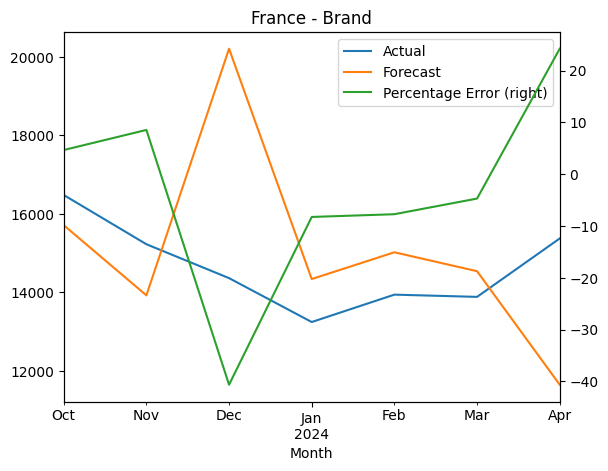

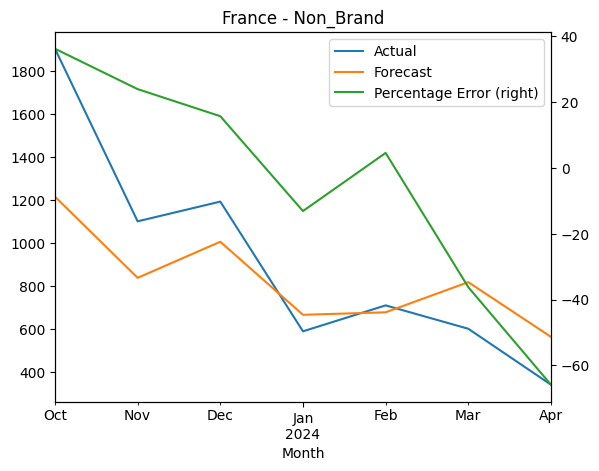

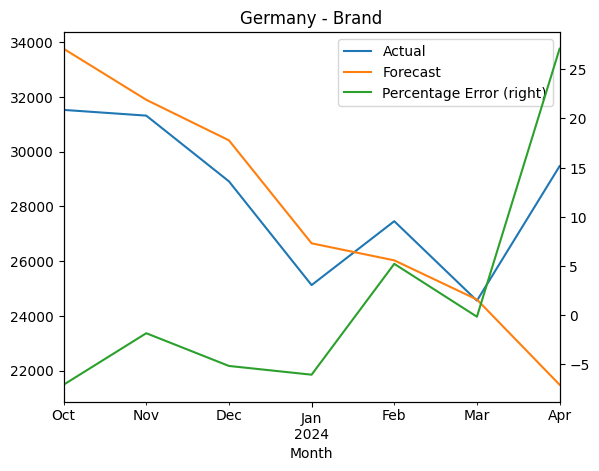

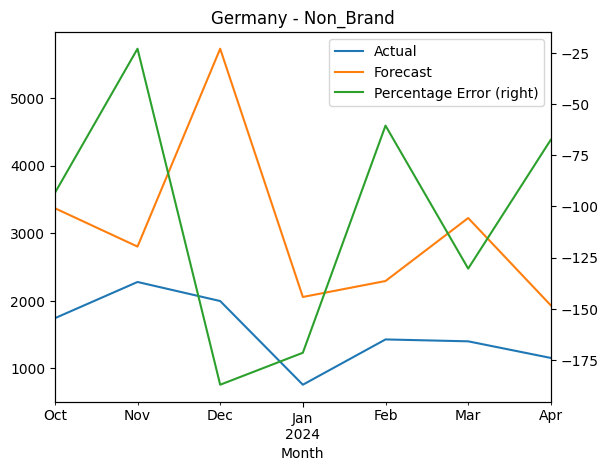

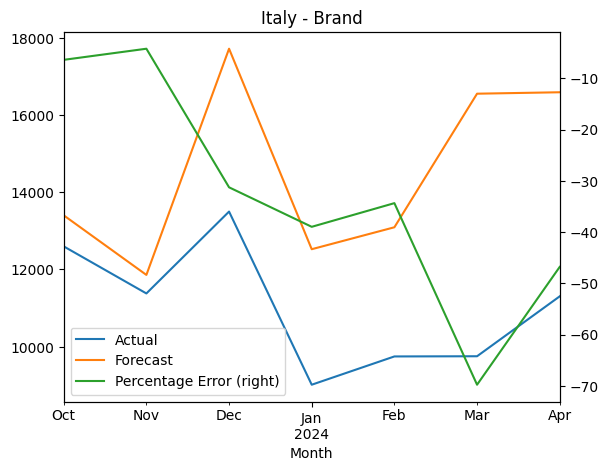

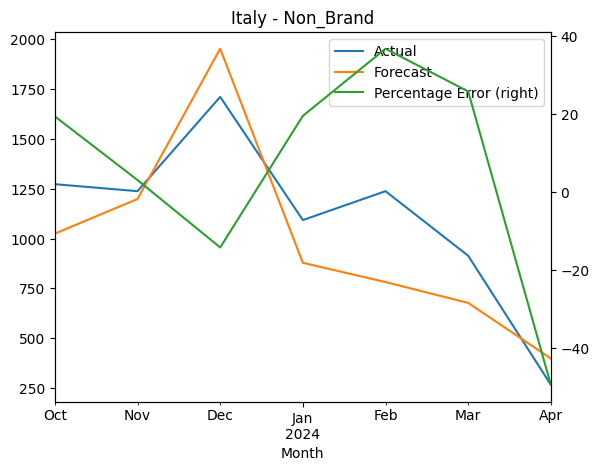

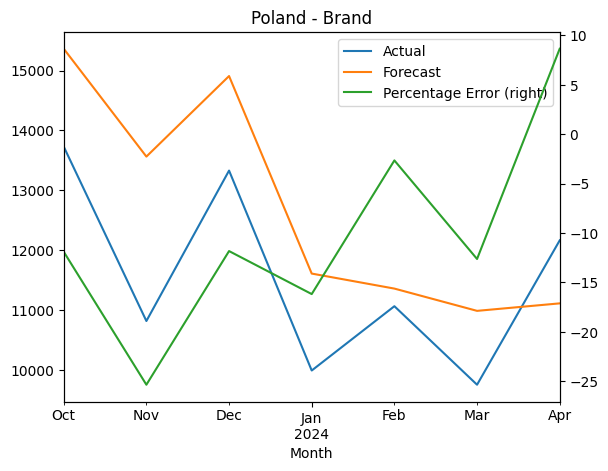

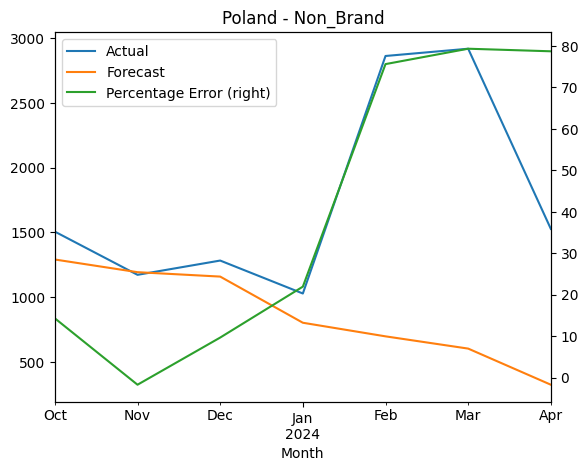

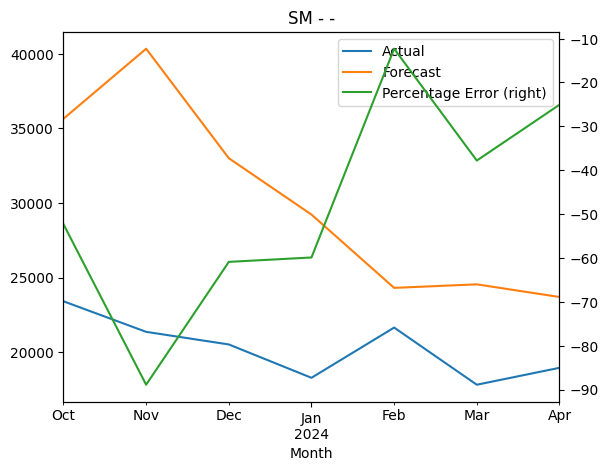

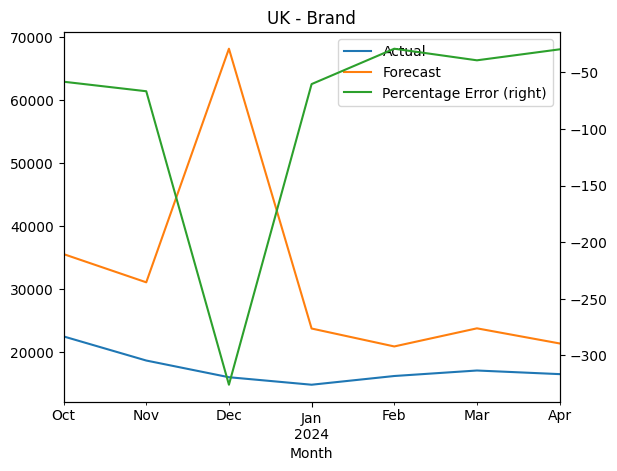

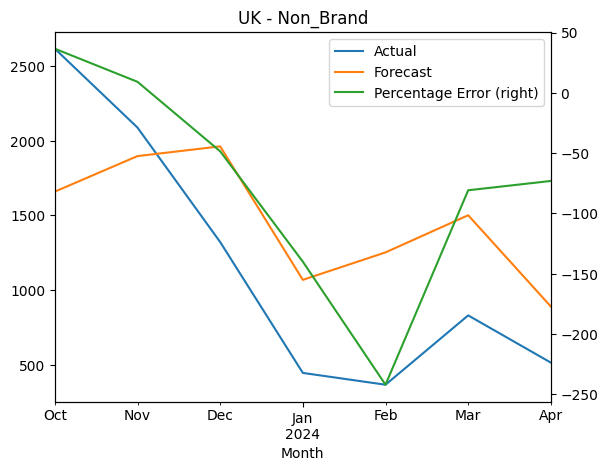

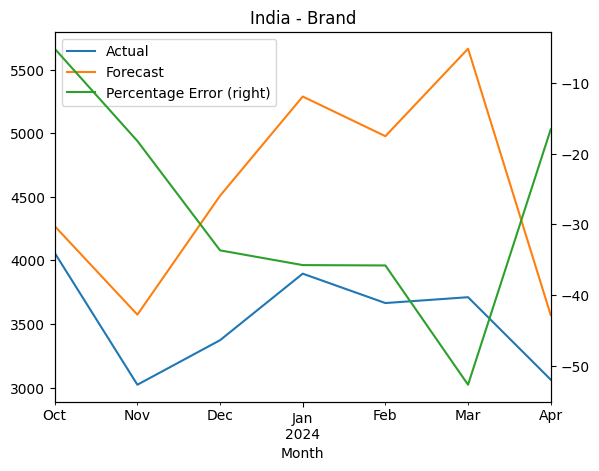

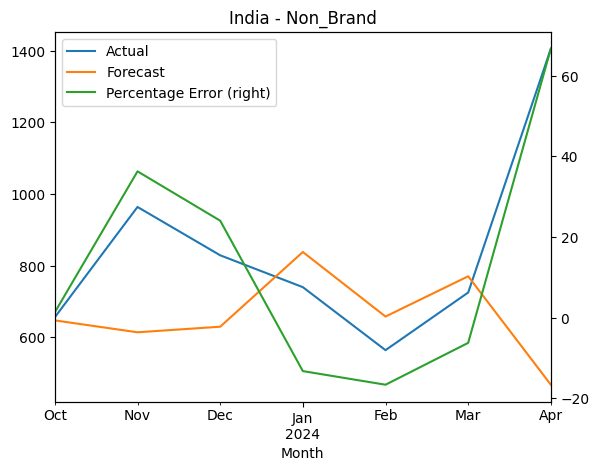

In [20]:
PlotAccuracyCharts(accuracy_df, cuts_df, query_item_list)


# Prophet parameter search

create a hyper parameter grid 

In [18]:
param_grid = {
    'changepoint_prior_scale': [ 0.05, 0.001], #0.1, 
    'seasonality_prior_scale': [10.0, 0.1, 0.01, 1.0 ], 
    'holidays_prior_scale': [10.0, 1.0,  0.1, 0.01  ], 
    'seasonality_mode': ['additive','multiplicative'], 
    'input_mode': ['additive','multiplicative'], 
    'weekday_or_weekend':['na', 'additive', 'multiplicative'],  
    'include_holiday': ['na', 'default'],#, 'customized'
    'covid_year_exclude':['False'],#, 'True'
    'covid_year_dummy':['na'],#, 'additive', 'multiplicative'
    'anomaly_2021':['na'],#, 'additive', 'multiplicative'],
    'generic_cost_split':['na', 'additive', 'multiplicative'],#
    'competitor_cost_split':['na', 'additive', 'multiplicative'], #
    'new_confirmed': ['na'],#,, 'additive', 'multiplicative'
    'dec_2022':['na']#, 'additive', 'multiplicative'
}


In [ ]:
# set the prophet parameter search with the hyper parameter grid created above and power flag as false (not needed)
search_engine = ProphetParameterSearch(param_grid = param_grid, power_flag = False, base_path=base_path) 
grid_brand = search_engine.search(cuts_df.loc[(cuts_df['market']=='Italy')&(cuts_df['funnel']=='Non_Brand')], final_df) # performs the grid search over the hyper parameter grid. exports a best result .csv table with best hyper parameters by split and a record df .csv table with full hyper parameters results # 



  0%|          | 0/1 [00:00<?, ?it/s]

19:46:38 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.45 Period MAE: 26.450000000000003
It's underpredicted.
Monthly Error: 57.31 Period MAE: 49.68


19:46:42 - cmdstanpy - INFO - Chain [1] start processing
19:46:42 - cmdstanpy - INFO - Chain [1] start processing
19:46:42 - cmdstanpy - INFO - Chain [1] done processing
19:46:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.57 Period MAE: 28.4


19:46:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 362.48 Period MAE: 200.95999999999998


19:46:45 - cmdstanpy - INFO - Chain [1] done processing
19:46:45 - cmdstanpy - INFO - Chain [1] start processing
19:46:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 353.4 Period MAE: 200.01000000000002


19:46:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.27 Period MAE: 45.92


19:46:48 - cmdstanpy - INFO - Chain [1] done processing
19:46:48 - cmdstanpy - INFO - Chain [1] start processing
19:46:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 333.29 Period MAE: 213.59


19:46:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 57.76 Period MAE: 50.07


19:46:50 - cmdstanpy - INFO - Chain [1] done processing
19:46:50 - cmdstanpy - INFO - Chain [1] start processing
19:46:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.79 Period MAE: 49.25


19:46:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 353.4 Period MAE: 200.01000000000002


19:46:53 - cmdstanpy - INFO - Chain [1] done processing
19:46:54 - cmdstanpy - INFO - Chain [1] start processing
19:46:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.54 Period MAE: 28.38
It's overpredicted.
Monthly Error: 354.57 Period MAE: 200.99


19:46:56 - cmdstanpy - INFO - Chain [1] start processing
19:46:56 - cmdstanpy - INFO - Chain [1] start processing
19:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

19:46:57 - cmdstanpy - INFO - Chain [1] done processing


330.12 Period MAE: 211.07


19:46:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.72 Period MAE: 44.64


19:46:59 - cmdstanpy - INFO - Chain [1] done processing
19:46:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 333.29 Period MAE: 213.59


19:47:00 - cmdstanpy - INFO - Chain [1] done processing
19:47:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.37 Period MAE: 27.16


19:47:01 - cmdstanpy - INFO - Chain [1] done processing
19:47:02 - cmdstanpy - INFO - Chain [1] start processing
19:47:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.2 Period MAE: 27.74
It's overpredicted.
Monthly Error: 329.99 Period MAE: 211.49


19:47:04 - cmdstanpy - INFO - Chain [1] start processing
19:47:04 - cmdstanpy - INFO - Chain [1] start processing
19:47:05 - cmdstanpy - INFO - Chain [1] done processing
19:47:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.74 Period MAE: 51.03
It's overpredicted.
Monthly Error: 337.37 Period MAE: 214.71


19:47:08 - cmdstanpy - INFO - Chain [1] start processing
19:47:09 - cmdstanpy - INFO - Chain [1] start processing
19:47:09 - cmdstanpy - INFO - Chain [1] done processing
19:47:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 360.99 Period MAE: 200.94


19:47:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.11 Period MAE: 28.43
It's overpredicted.
Monthly Error: 349.04 Period MAE: 198.62


19:47:12 - cmdstanpy - INFO - Chain [1] start processing
19:47:12 - cmdstanpy - INFO - Chain [1] done processing
19:47:12 - cmdstanpy - INFO - Chain [1] done processing
19:47:13 - cmdstanpy - INFO - Chain [1] start processing
19:47:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.91 Period MAE: 43.19


19:47:15 - cmdstanpy - INFO - Chain [1] start processing
19:47:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 341.13 Period MAE: 214.82999999999998
It's underpredicted.
Monthly Error: 51.54 Period MAE: 44.04


19:47:17 - cmdstanpy - INFO - Chain [1] start processing
19:47:17 - cmdstanpy - INFO - Chain [1] start processing
19:47:17 - cmdstanpy - INFO - Chain [1] done processing
19:47:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 347.72 Period MAE: 197.38
It's underpredicted.
Monthly Error: 50.6 Period MAE: 44.79


19:47:20 - cmdstanpy - INFO - Chain [1] start processing
19:47:20 - cmdstanpy - INFO - Chain [1] start processing
19:47:21 - cmdstanpy - INFO - Chain [1] done processing
19:47:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 354.04 Period MAE: 202.88


19:47:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.02 Period MAE: 26.08
It's overpredicted.
Monthly Error: 341.97 Period MAE: 214.21


19:47:24 - cmdstanpy - INFO - Chain [1] start processing
19:47:24 - cmdstanpy - INFO - Chain [1] done processing
19:47:24 - cmdstanpy - INFO - Chain [1] done processing
19:47:24 - cmdstanpy - INFO - Chain [1] start processing
19:47:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.0 Period MAE: 41.3
It's overpredicted.
Monthly Error: 341.14 Period MAE: 214.82999999999998


19:47:27 - cmdstanpy - INFO - Chain [1] start processing
19:47:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.83 Period MAE:

19:47:28 - cmdstanpy - INFO - Chain [1] done processing


 28.22


19:47:28 - cmdstanpy - INFO - Chain [1] start processing
19:47:28 - cmdstanpy - INFO - Chain [1] done processing
19:47:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.83 Period MAE: 26.889999999999997
It's overpredicted.


19:47:31 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 341.97 Period MAE: 214.21


19:47:31 - cmdstanpy - INFO - Chain [1] start processing
19:47:31 - cmdstanpy - INFO - Chain [1] done processing
19:47:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.68 Period MAE: 52.239999999999995


19:47:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 335.3 Period MAE: 214.86


19:47:35 - cmdstanpy - INFO - Chain [1] start processing
19:47:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.98 Period MAE: 21.099999999999998


19:47:35 - cmdstanpy - INFO - Chain [1] done processing
19:47:36 - cmdstanpy - INFO - Chain [1] start processing
19:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.63 Period MAE: 40.949999999999996


19:47:37 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.9 Period MAE: 35.099999999999994
It's underpredicted.
Monthly Error: 54.41 Period MAE: 46.760000000000005


19:47:39 - cmdstanpy - INFO - Chain [1] start processing
19:47:39 - cmdstanpy - INFO - Chain [1] start processing
19:47:39 - cmdstanpy - INFO - Chain [1] done processing
19:47:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.94 Period MAE: 26.26


19:47:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.87 Period MAE: 44.190000000000005


19:47:43 - cmdstanpy - INFO - Chain [1] done processing
19:47:43 - cmdstanpy - INFO - Chain [1] start processing
19:47:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.9 Period MAE: 35.099999999999994


19:47:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.12 Period MAE: 44.68
It's overpredicted.
Monthly Error: 56.87 Period MAE: 40.79

19:47:45 - cmdstanpy - INFO - Chain [1] done processing


19:47:45 - cmdstanpy - INFO - Chain [1] start processing
19:47:46 - cmdstanpy - INFO - Chain [1] done processing
19:47:46 - cmdstanpy - INFO - Chain [1] start processing
19:47:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.71 Period MAE: 43.07


19:47:48 - cmdstanpy - INFO - Chain [1] start processing
19:47:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.81 Period MAE: 47.07
It's overpredicted.
Monthly Error: 36.72 Period MAE: 28.139999999999997


19:47:50 - cmdstanpy - INFO - Chain [1] start processing
19:47:51 - cmdstanpy - INFO - Chain [1] start processing
19:47:51 - cmdstanpy - INFO - Chain [1] done processing
19:47:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.94 Period MAE: 26.26
It's underpredicted.
Monthly Error: 52.54 Period MAE: 44.61


19:47:54 - cmdstanpy - INFO - Chain [1] start processing
19:47:54 - cmdstanpy - INFO - Chain [1] start processing
19:47:55 - cmdstanpy - INFO - Chain [1] done processing
19:47:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.71 Period MAE: 28.139999999999997


19:47:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 50.89 Period MAE: 32.65
It's underpredicted.
Monthly Error: 37.21 Period MAE: 27.12


19:47:57 - cmdstanpy - INFO - Chain [1] done processing
19:47:58 - cmdstanpy - INFO - Chain [1] start processing
19:47:58 - cmdstanpy - INFO - Chain [1] start processing
19:47:58 - cmdstanpy - INFO - Chain [1] done processing
19:47:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.71 Period MAE: 43.1


19:48:00 - cmdstanpy - INFO - Chain [1] start processing
19:48:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.41 Period MAE: 17.560000000000002
It's underpredicted.
Monthly Error: 50.71 Period MAE: 43.309999999999995


19:48:02 - cmdstanpy - INFO - Chain [1] start processing
19:48:02 - cmdstanpy - INFO - Chain [1] start processing
19:48:02 - cmdstanpy - INFO - Chain [1] done processing
19:48:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.64 Period MAE: 31.480000000000004
It's underpredicted.
Monthly Error: 49.81 Period MAE: 42.370000000000005


19:48:07 - cmdstanpy - INFO - Chain [1] start processing
19:48:07 - cmdstanpy - INFO - Chain [1] start processing
19:48:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.81 Period MAE: 24.18


19:48:08 - cmdstanpy - INFO - Chain [1] done processing
19:48:08 - cmdstanpy - INFO - Chain [1] start processing
19:48:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.64 Period MAE: 31.480000000000004


19:48:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.88 Period MAE: 42.44


19:48:10 - cmdstanpy - INFO - Chain [1] done processing
19:48:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.05 Period MAE: 42.57


19:48:12 - cmdstanpy - INFO - Chain [1] start processing
19:48:12 - cmdstanpy - INFO - Chain [1] done processing
19:48:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.09 Period MAE: 29.12
It's underpredicted.
Monthly Error: 48.13 Period MAE: 40.79


19:48:15 - cmdstanpy - INFO - Chain [1] start processing
19:48:15 - cmdstanpy - INFO - Chain [1] start processing
19:48:15 - cmdstanpy - INFO - Chain [1] done processing
19:48:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.0 Period MAE: 27.58


19:48:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.9 Period MAE: 45.17
It's overpredicted.
Monthly Error: 39.81 Period MAE: 24.18


19:48:18 - cmdstanpy - INFO - Chain [1] done processing
19:48:18 - cmdstanpy - INFO - Chain [1] start processing
19:48:19 - cmdstanpy - INFO - Chain [1] start processing
19:48:19 - cmdstanpy - INFO - Chain [1] done processing
19:48:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error: 71.23 Period MAE: 73.48


20:07:23 - cmdstanpy - INFO - Chain [1] done processing
20:07:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.85 Period MAE: 59.01


20:07:24 - cmdstanpy - INFO - Chain [1] start processing
20:07:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.05 Period MAE: 69.23


20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:26 - cmdstanpy - INFO - Chain [1] start processing
20:07:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 271.99 Period MAE: 320.56
It's underpredicted.
Monthly Error: 98.97 Period MAE: 98.81


20:07:27 - cmdstanpy - INFO - Chain [1] start processing
20:07:28 - cmdstanpy - INFO - Chain [1] start processing
20:07:28 - cmdstanpy - INFO - Chain [1] done processing
20:07:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 81.81 Period MAE: 78.85


20:07:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.51 Period MAE: 39.68
It's overpredicted.
Monthly Error: 275.3 Period MAE: 333.53000000000003


20:07:32 - cmdstanpy - INFO - Chain [1] done processing
20:07:32 - cmdstanpy - INFO - Chain [1] start processing
20:07:33 - cmdstanpy - INFO - Chain [1] start processing
20:07:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 269.69 Period MAE: 326.57
It's underpredicted.
Monthly Error: 65.68 Period MAE: 71.38


20:07:35 - cmdstanpy - INFO - Chain [1] start processing
20:07:35 - cmdstanpy - INFO - Chain [1] done processing
20:07:35 - cmdstanpy - INFO - Chain [1] done processing
20:07:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.49 Period MAE: 39.050000000000004


20:07:37 - cmdstanpy - INFO - Chain [1] start processing
20:07:38 - cmdstanpy - INFO - Chain [1] done processing
20:07:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.52 Period MAE: 23.599999999999998
It's underpredicted.
Monthly Error: 54.01 Period MAE: 39.0


20:07:40 - cmdstanpy - INFO - Chain [1] start processing
20:07:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 290.72

20:07:41 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 331.92


20:07:41 - cmdstanpy - INFO - Chain [1] done processing
20:07:42 - cmdstanpy - INFO - Chain [1] start processing
20:07:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.82 Period MAE: 71.23
It's overpredicted.
Monthly Error: 284.6 Period MAE: 327.22


20:07:44 - cmdstanpy - INFO - Chain [1] start processing
20:07:45 - cmdstanpy - INFO - Chain [1] start processing
20:07:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.71 Period MAE: 70.7


20:07:46 - cmdstanpy - INFO - Chain [1] start processing
20:07:46 - cmdstanpy - INFO - Chain [1] done processing
20:07:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 259.74 Period MAE: 315.05


20:07:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.87 Period MAE: 70.5


20:07:49 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 268.49 Period MAE: 329.47
It's underpredicted.
Monthly Error: 66.89 Period MAE: 72.26


20:07:52 - cmdstanpy - INFO - Chain [1] start processing
20:07:52 - cmdstanpy - INFO - Chain [1] start processing
20:07:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 259.53 Period MAE: 313.08


20:07:53 - cmdstanpy - INFO - Chain [1] done processing
20:07:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.06 Period MAE: 98.91
It's underpredicted.
Monthly Error: 32.65 Period MAE: 0.64


20:07:56 - cmdstanpy - INFO - Chain [1] start processing
20:07:56 - cmdstanpy - INFO - Chain [1] done processing
20:07:56 - cmdstanpy - INFO - Chain [1] done processing
20:07:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.34 Period MAE: 39.69


20:07:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 268.16 Period MAE: 332.88


20:07:59 - cmdstanpy - INFO - Chain [1] start processing
20:07:59 - cmdstanpy - INFO - Chain [1] start processing
20:07:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.39 Period MAE: 71.27


20:08:01 - cmdstanpy - INFO - Chain [1] start processing
20:08:02 - cmdstanpy - INFO - Chain [1] done processing
20:08:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 312.32 Period MAE: 340.8


20:08:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.0 Period MAE: 38.96


20:08:06 - cmdstanpy - INFO - Chain [1] start processing
20:08:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 292.59 Period MAE: 346.14


20:08:07 - cmdstanpy - INFO - Chain [1] start processing
20:08:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 312.29 Period MAE: 340.79


20:08:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.46 Period MAE:

20:08:10 - cmdstanpy - INFO - Chain [1] start processing


 40.11


20:08:10 - cmdstanpy - INFO - Chain [1] start processing
20:08:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.36 Period MAE: 70.21


20:08:12 - cmdstanpy - INFO - Chain [1] start processing
20:08:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 258.77 Period MAE: 319.27


20:08:13 - cmdstanpy - INFO - Chain [1] done processing
20:08:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.59 Period MAE: 71.43


20:08:15 - cmdstanpy - INFO - Chain [1] start processing
20:08:16 - cmdstanpy - INFO - Chain [1] done processing
20:08:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.71 Period MAE: 3.9600000000000004


20:08:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.38 Period MAE: 70.76


20:08:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.01 Period MAE: 23.47


20:08:19 - cmdstanpy - INFO - Chain [1] done processing
20:08:19 - cmdstanpy - INFO - Chain [1] done processing
20:08:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.44 Period MAE: 72.0


20:08:22 - cmdstanpy - INFO - Chain [1] start processing
20:08:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.12 Period MAE: 3.16


20:08:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 300.72 Period MAE: 347.58


20:08:26 - cmdstanpy - INFO - Chain [1] start processing
20:08:27 - cmdstanpy - INFO - Chain [1] done processing
20:08:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.83 Period MAE: 68.88


20:08:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 98.13 Period MAE: 98.87


20:08:29 - cmdstanpy - INFO - Chain [1] start processing
20:08:29 - cmdstanpy - INFO - Chain [1] done processing
20:08:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.65 Period MAE: 45.879999999999995
It's underpredicted.
Monthly Error: 36.34 Period MAE: 38.37


20:08:33 - cmdstanpy - INFO - Chain [1] start processing
20:08:33 - cmdstanpy - INFO - Chain [1] start processing
20:08:34 - cmdstanpy - INFO - Chain [1] done processing
20:08:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.51 Period MAE: 55.33


20:08:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.57 Period MAE: 86.74


20:08:37 - cmdstanpy - INFO - Chain [1] start processing
20:08:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.61 Period MAE: 38.81


20:08:41 - cmdstanpy - INFO - Chain [1] start processing
20:08:41 - cmdstanpy - INFO - Chain [1] done processing
20:08:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.11 Period MAE: 42.93
It's underpredicted.
Monthly Error: 54.81 Period MAE: 46.160000000000004


20:08:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 252.15 Period MAE: 285.23


20:08:43 - cmdstanpy - INFO - Chain [1] start processing
20:08:44 - cmdstanpy - INFO - Chain [1] done processing
20:08:44 - cmdstanpy - INFO - Chain [1] start processing
20:08:44 - cmdstanpy - INFO - Chain [1] done processing
20:08:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.2 Period MAE: 85.37
It's underpredicted.
Monthly Error: 46.71 Period MAE: 43.97
It's underpredicted.
Monthly Error:

20:08:50 - cmdstanpy - INFO - Chain [1] start processing


 63.76 Period MAE: 56.82000000000001


20:08:50 - cmdstanpy - INFO - Chain [1] done processing
20:08:50 - cmdstanpy - INFO - Chain [1] start processing
20:08:51 - cmdstanpy - INFO - Chain [1] start processing
20:08:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.73 Period MAE: 86.95


20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.13 Period MAE: 44.06


20:08:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.23 Period MAE: 53.81


20:08:59 - cmdstanpy - INFO - Chain [1] done processing
20:08:59 - cmdstanpy - INFO - Chain [1] done processing
20:08:59 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.26 Period MAE: 83.89
It's underpredicted.
Monthly Error: 89.35 Period MAE: 87.75


20:09:02 - cmdstanpy - INFO - Chain [1] start processing
20:09:02 - cmdstanpy - INFO - Chain [1] start processing
20:09:03 - cmdstanpy - INFO - Chain [1] done processing
20:09:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.51 Period MAE: 70.41


20:09:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 98.57 Period MAE: 99.24


20:09:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.5 Period MAE: 36.69


20:09:10 - cmdstanpy - INFO - Chain [1] done processing
20:09:10 - cmdstanpy - INFO - Chain [1] done processing
20:09:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.53 Period MAE: 46.79


20:09:13 - cmdstanpy - INFO - Chain [1] start processing
20:09:13 - cmdstanpy - INFO - Chain [1] done processing
20:09:15 - cmdstanpy - INFO - Chain [1] done processing
20:09:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.62 Period MAE: 59.78


20:09:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.36 Period MAE: 86.50999999999999


20:09:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.48 Period MAE: 42.1


20:09:19 - cmdstanpy - INFO - Chain [1] done processing
20:09:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.76 Period MAE: 41.79


20:09:20 - cmdstanpy - INFO - Chain [1] start processing
20:09:21 - cmdstanpy - INFO - Chain [1] done processing
20:09:21 - cmdstanpy - INFO - Chain [1] done processing
20:09:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.14 Period MAE: 77.8


20:09:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.9 Period MAE: 43.71It's underpredicted.
Monthly Error:
 39.93 Period MAE: 43.61


20:09:26 - cmdstanpy - INFO - Chain [1] start processing
20:09:26 - cmdstanpy - INFO - Chain [1] start processing
20:09:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.53 Period MAE: 43.94


20:09:28 - cmdstanpy - INFO - Chain [1] start processing
20:09:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.08 Period MAE: 59.050000000000004


20:09:33 - cmdstanpy - INFO - Chain [1] done processing
20:09:33 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.25It's underpredicted.
Monthly Error:  47.94Period MAE:  Period MAE: 46.5187.62



20:09:36 - cmdstanpy - INFO - Chain [1] start processing
20:09:36 - cmdstanpy - INFO - Chain [1] start processing
20:09:37 - cmdstanpy - INFO - Chain [1] done processing
20:09:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.9 Period MAE: 85.07000000000001


20:09:38 - cmdstanpy - INFO - Chain [1] start processing
20:09:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.36 Period MAE: 25.0


20:09:40 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.09 Period MAE: 47.370000000000005


20:09:42 - cmdstanpy - INFO - Chain [1] done processing
20:09:43 - cmdstanpy - INFO - Chain [1] start processing
20:09:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error: 
361.77 Period MAE:Monthly Error: 200.4 65.76 
Period MAE: 59.96


20:09:44 - cmdstanpy - INFO - Chain [1] start processing
20:09:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.76 Period MAE:

20:09:45 - cmdstanpy - INFO - Chain [1] done processing


 87.0


20:09:45 - cmdstanpy - INFO - Chain [1] start processing
20:09:46 - cmdstanpy - INFO - Chain [1] done processing
20:09:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.88 Period MAE: 27.67
It's underpredicted.
Monthly Error: 54.45

20:09:48 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 46.760000000000005


20:09:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 353.76 Period MAE: 

20:09:49 - cmdstanpy - INFO - Chain [1] start processing


200.3


20:09:49 - cmdstanpy - INFO - Chain [1] start processing
20:09:50 - cmdstanpy - INFO - Chain [1] done processing
20:09:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 363.7 Period MAE: 214.97000000000003


20:09:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.99 Period MAE: 43.419999999999995

20:09:52 - cmdstanpy - INFO - Chain [1] done processing


20:09:52 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.56 Period MAE: 48.75
It's overpredicted.


20:09:54 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 353.76 Period MAE: 200.3


20:09:55 - cmdstanpy - INFO - Chain [1] start processing
20:09:55 - cmdstanpy - INFO - Chain [1] done processing
20:09:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 356.36 Period MAE: 202.59999999999997


20:09:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.16 Period MAE: 29.709999999999997


20:09:58 - cmdstanpy - INFO - Chain [1] start processing
20:09:58 - cmdstanpy - INFO - Chain [1] done processing
20:09:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 358.51 Period MAE: 214.56


20:10:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 57.15 Period MAE: 49.91


20:10:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

20:10:01 - cmdstanpy - INFO - Chain [1] start processing


 363.7 Period MAE: 214.97000000000003


20:10:01 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.58 Period MAE: 31.180000000000003


20:10:04 - cmdstanpy - INFO - Chain [1] start processing
20:10:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.62 Period MAE: 26.93
It's overpredicted.
Monthly Error: 358.51 Period MAE: 214.56


20:10:06 - cmdstanpy - INFO - Chain [1] start processing
20:10:06 - cmdstanpy - INFO - Chain [1] start processing
20:10:06 - cmdstanpy - INFO - Chain [1] done processing
20:10:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 356.63 Period MAE: 219.36
It's underpredicted.
Monthly Error: 51.46 Period MAE: 43.87


20:10:09 - cmdstanpy - INFO - Chain [1] start processing
20:10:10 - cmdstanpy - INFO - Chain [1] start processing
20:10:10 - cmdstanpy - INFO - Chain [1] done processing
20:10:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 360.15 Period MAE: 199.37


20:10:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.96 Period MAE: It's overpredicted.30.81

Monthly Error: 

20:10:12 - cmdstanpy - INFO - Chain [1] done processing


352.76 Period MAE: 200.05


20:10:13 - cmdstanpy - INFO - Chain [1] start processing
20:10:13 - cmdstanpy - INFO - Chain [1] start processing
20:10:13 - cmdstanpy - INFO - Chain [1] done processing
20:10:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.84 Period MAE: 42.32


20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 363.61 Period MAE:It's underpredicted. 
215.45999999999998Monthly Error:
 49.14 Period MAE: 41.67


20:10:17 - cmdstanpy - INFO - Chain [1] start processing
20:10:17 - cmdstanpy - INFO - Chain [1] start processing
20:10:17 - cmdstanpy - INFO - Chain [1] done processing
20:10:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.352.76
Monthly Error:  Period MAE:56.11 Period MAE:  200.0549.19



20:10:20 - cmdstanpy - INFO - Chain [1] start processing
20:10:20 - cmdstanpy - INFO - Chain [1] start processing
20:10:20 - cmdstanpy - INFO - Chain [1] done processing
20:10:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 355.41 Period MAE: 202.88


20:10:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.27 Period MAE: 27.35


20:10:23 - cmdstanpy - INFO - Chain [1] done processing
20:10:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 352.52 Period MAE: 211.78


20:10:24 - cmdstanpy - INFO - Chain [1] done processing
20:10:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 57.34 Period MAE: 50.18


20:10:26 - cmdstanpy - INFO - Chain [1] done processing
20:10:26 - cmdstanpy - INFO - Chain [1] start processing
20:10:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 363.61 Period MAE: 215.45999999999998


20:10:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.53 Period MAE: 

20:10:28 - cmdstanpy - INFO - Chain [1] done processing


27.82


20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 351.73 Period MAE: 211.16000000000003
It's underpredicted.
Monthly Error: 37.2 Period MAE:24.9 


20:10:30 - cmdstanpy - INFO - Chain [1] start processing
20:10:31 - cmdstanpy - INFO - Chain [1] start processing
20:10:31 - cmdstanpy - INFO - Chain [1] done processing
20:10:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 354.21 Period MAE: 217.93999999999997
It's underpredicted.
Monthly Error: 54.61 Period MAE: 46.61

20:10:33 - cmdstanpy - INFO - Chain [1] start processing


20:10:34 - cmdstanpy - INFO - Chain [1] start processing
20:10:34 - cmdstanpy - INFO - Chain [1] done processing
20:10:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.11 Period MAE: 19.2


20:10:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


20:10:36 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 41.16 Period MAE: 33.14


20:10:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


20:10:37 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 43.65 Period MAE: 31.4


20:10:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.11 Period MAE: 43.4


20:10:39 - cmdstanpy - INFO - Chain [1] done processing
20:10:39 - cmdstanpy - INFO - Chain [1] start processing
20:10:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 27.04 Period MAE: 14.59
It's underpredicted.
Monthly Error: 53.3 

20:10:41 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 45.79


20:10:42 - cmdstanpy - INFO - Chain [1] start processing
20:10:42 - cmdstanpy - INFO - Chain [1] done processing
20:10:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.65 Period MAE: 31.4


20:10:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.51 Period MAE: 52.7


20:10:45 - cmdstanpy - INFO - Chain [1] start processing
20:10:45 - cmdstanpy - INFO - Chain [1] done processing
20:10:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.99 Period MAE: 41.39


20:10:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.19 Period MAE: 32.4


20:10:48 - cmdstanpy - INFO - Chain [1] done processing
20:10:48 - cmdstanpy - INFO - Chain [1] start processing
20:10:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.74 Period MAE: 29.98


20:10:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 60.72 Period MAE: 53.949999999999996


20:10:50 - cmdstanpy - INFO - Chain [1] start processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 26.94 Period MAE: 14.510000000000002
It's underpredicted.
Monthly Error: 41.0 Period MAE: 33.19


20:10:53 - cmdstanpy - INFO - Chain [1] start processing
20:10:53 - cmdstanpy - INFO - Chain [1] start processing
20:10:53 - cmdstanpy - INFO - Chain [1] done processing
20:10:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.74 Period MAE: 29.98


20:10:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.75 Period MAE: 27.500000000000004


20:10:56 - cmdstanpy - INFO - Chain [1] done processing
20:10:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.33 Period MAE: 36.69


20:10:57 - cmdstanpy - INFO - Chain [1] done processing
20:10:57 - cmdstanpy - INFO - Chain [1] start processing
20:10:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.45 Period MAE: 44.879999999999995


20:10:59 - cmdstanpy - INFO - Chain [1] start processing
20:10:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.92 Period MAE: 17.560000000000002


20:11:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.2 Period MAE: 35.010000000000005


20:11:01 - cmdstanpy - INFO - Chain [1] start processing
20:11:01 - cmdstanpy - INFO - Chain [1] done processing
20:11:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.89 Period MAE: 31.4
It's underpredicted.
Monthly Error: 52.31 Period MAE: 44.76


20:11:05 - cmdstanpy - INFO - Chain [1] start processing
20:11:05 - cmdstanpy - INFO - Chain [1] start processing
20:11:05 - cmdstanpy - INFO - Chain [1] done processing
20:11:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.95 Period MAE: 17.72


20:11:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.83 Period MAE: 47.29
It's overpredicted.
Monthly Error: 43.89 Period MAE: 31.4


20:11:09 - cmdstanpy - INFO - Chain [1] done processing
20:11:09 - cmdstanpy - INFO - Chain [1] start processing
20:11:09 - cmdstanpy - INFO - Chain [1] start processing
20:11:09 - cmdstanpy - INFO - Chain [1] done processing
20:11:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.31 Period MAE: 51.29


20:11:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.58 Period MAE: 40.9


20:11:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.73 Period MAE: 34.17


20:11:13 - cmdstanpy - INFO - Chain [1] start processing
20:11:14 - cmdstanpy - INFO - Chain [1] start processing
20:11:14 - cmdstanpy - INFO - Chain [1] done processing
20:11:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.44 Period MAE: 25.03


20:11:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 55.6 Period MAE: 48.54


20:11:18 - cmdstanpy - INFO - Chain [1] done processing
20:11:18 - cmdstanpy - INFO - Chain [1] start processing
20:11:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.95 Period MAE: 17.72


20:11:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.96 Period MAE: 35.55
It's overpredicted.
Monthly Error: 34.14 Period MAE: 24.86


20:11:20 - cmdstanpy - INFO - Chain [1] done processing
20:11:20 - cmdstanpy - INFO - Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.9 Period MAE: 22.74


20:11:23 - cmdstanpy - INFO - Chain [1] start processing
20:11:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.33 Period MAE: 38.83
It's overpredicted.
Monthly Error: 38.57 Period MAE:

20:11:24 - cmdstanpy - INFO - Chain [1] start processing


 21.77


20:11:25 - cmdstanpy - INFO - Chain [1] done processing
20:11:25 - cmdstanpy - INFO - Chain [1] start processing
20:11:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.05 Period MAE: 21.44


20:11:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 340.16 Period MAE: 199.04999999999998


20:11:28 - cmdstanpy - INFO - Chain [1] done processing
20:11:28 - cmdstanpy - INFO - Chain [1] start processing
20:11:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 339.02 Period MAE: It's underpredicted.203.22

Monthly Error: 43.43 Period MAE: 36.199999999999996


20:11:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 286.94 Period MAE:

20:11:31 - cmdstanpy - INFO - Chain [1] start processing


 211.64999999999998


20:11:31 - cmdstanpy - INFO - Chain [1] done processing
20:11:31 - cmdstanpy - INFO - Chain [1] done processing
20:11:32 - cmdstanpy - INFO - Chain [1] start processing
20:11:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.85 Period MAE: 36.88


20:11:34 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.34 Period MAE: 41.82
It's overpredicted.
Monthly Error: 339.02 Period MAE: 203.22


20:11:35 - cmdstanpy - INFO - Chain [1] start processing
20:11:35 - cmdstanpy - INFO - Chain [1] start processing
20:11:36 - cmdstanpy - INFO - Chain [1] done processing
20:11:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 335.79 Period MAE: 200.99999999999997
It's underpredicted.
Monthly Error: 34.08 Period MAE: 24.310000000000002


20:11:38 - cmdstanpy - INFO - Chain [1] start processing
20:11:38 - cmdstanpy - INFO - Chain [1] start processing
20:11:39 - cmdstanpy - INFO - Chain [1] done processing
20:11:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 284.27 Period MAE: 209.09


20:11:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.71 Period MAE: 37.43
It's overpredicted.
Monthly Error: 286.94 Period MAE: 

20:11:42 - cmdstanpy - INFO - Chain [1] done processing


211.66


20:11:43 - cmdstanpy - INFO - Chain [1] start processing
20:11:43 - cmdstanpy - INFO - Chain [1] done processing
20:11:43 - cmdstanpy - INFO - Chain [1] start processing
20:11:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.09 Period MAE: 27.13


20:11:46 - cmdstanpy - INFO - Chain [1] start processing
20:11:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.79 Period MAE: 24.69
It's overpredicted.
Monthly Error: 284.27 Period MAE: 209.09


20:11:47 - cmdstanpy - INFO - Chain [1] start processing
20:11:47 - cmdstanpy - INFO - Chain [1] start processing
20:11:47 - cmdstanpy - INFO - Chain [1] done processing
20:11:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 286.68 Period MAE: 213.24999999999997
It's underpredicted.
Monthly Error: 43.46 Period MAE: 36.38


20:11:50 - cmdstanpy - INFO - Chain [1] start processing
20:11:50 - cmdstanpy - INFO - Chain [1] start processing
20:11:51 - cmdstanpy - INFO - Chain [1] done processing
20:11:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 316.7 Period MAE: 197.41
It's underpredicted.
Monthly Error: 31.5 Period MAE: 22.6


20:11:53 - cmdstanpy - INFO - Chain [1] start processing
20:11:53 - cmdstanpy - INFO - Chain [1] start processing
20:11:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 322.58 Period MAE: 202.5


20:11:54 - cmdstanpy - INFO - Chain [1] done processing
20:11:55 - cmdstanpy - INFO - Chain [1] start processing
20:11:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.06 Period MAE: 35.67
It's overpredicted.
Monthly Error: 272.49 Period MAE: 206.93


20:11:57 - cmdstanpy - INFO - Chain [1] start processing
20:11:58 - cmdstanpy - INFO - Chain [1] start processing
20:11:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.32 Period MAE: 34.42


20:11:58 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 322.58 Period MAE: 202.49


20:12:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.55 Period MAE: 40.129999999999995


20:12:01 - cmdstanpy - INFO - Chain [1] start processing
20:12:02 - cmdstanpy - INFO - Chain [1] done processing
20:12:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 314.8 Period MAE: 196.8
It's underpredicted.
Monthly Error: 31.14 Period MAE: 22.38


20:12:05 - cmdstanpy - INFO - Chain [1] start processing
20:12:06 - cmdstanpy - INFO - Chain [1] start processing
20:12:06 - cmdstanpy - INFO - Chain [1] done processing
20:12:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 306.44 Period MAE: 209.42


20:12:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.32 Period MAE: 

20:12:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.34.25
Monthly Error:
 273.61 Period MAE: 207.58999999999997


20:12:09 - cmdstanpy - INFO - Chain [1] start processing
20:12:09 - cmdstanpy - INFO - Chain [1] start processing
20:12:10 - cmdstanpy - INFO - Chain [1] done processing
20:12:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 295.87 Period MAE: 328.57


20:26:09 - cmdstanpy - INFO - Chain [1] done processing
20:26:09 - cmdstanpy - INFO - Chain [1] start processing
20:26:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.65 Period MAE: 47.08


20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 313.35 Period MAE: 336.36
It's underpredicted.
Monthly Error: 46.63 Period MAE: 50.160000000000004


20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:13 - cmdstanpy - INFO - Chain [1] done processing
20:26:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 343.02 Period MAE: 343.23
It's underpredicted.
Monthly Error: 95.98 Period MAE: 95.16


20:26:16 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 342.62 Period MAE: 343.62


20:26:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.61 Period MAE: 50.13999999999999


20:26:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 310.47 Period MAE: 332.27000000000004


20:26:21 - cmdstanpy - INFO - Chain [1] start processing
20:26:21 - cmdstanpy - INFO - Chain [1] start processing
20:26:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.45 Period MAE: 91.10000000000001


20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 340.35 Period MAE: 343.25
It's underpredicted.
Monthly Error: 96.95 Period MAE: 96.32


20:26:25 - cmdstanpy - INFO - Chain [1] start processing
20:26:25 - cmdstanpy - INFO - Chain [1] start processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 337.86 Period MAE: 344.38
It's underpredicted.
Monthly Error: 46.13 Period MAE:

20:26:28 - cmdstanpy - INFO - Chain [1] start processing


 48.79


20:26:29 - cmdstanpy - INFO - Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 335.15 Period MAE: 341.69


20:26:29 - cmdstanpy - INFO - Chain [1] done processing
20:26:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 95.86 Period MAE: 95.03


20:26:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 314.56 Period MAE: 337.04


20:26:32 - cmdstanpy - INFO - Chain [1] start processing
20:26:32 - cmdstanpy - INFO - Chain [1] done processing
20:26:33 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.29 Period MAE: 49.19


20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 321.29 Period MAE: 338.05
It's underpredicted.


20:26:36 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 45.74 Period MAE: 46.92


20:26:37 - cmdstanpy - INFO - Chain [1] start processing
20:26:37 - cmdstanpy - INFO - Chain [1] done processing
20:26:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 
Monthly Error:312.12  46.59 Period MAE:Period MAE:  336.2850.09



20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 312.83 Period MAE: 336.96000000000004


20:26:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 339.48 Period MAE: 342.12
It's underpredicted.
Monthly Error: 95.99 Period MAE: 95.19


20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:44 - cmdstanpy - INFO - Chain [1] done processing
20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:44 - cmdstanpy - INFO - Chain [1] done processing
20:26:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.56 It's overpredicted.Period MAE:
 Monthly Error: 310.74 Period MAE:50.080000000000005
 336.32


20:26:48 - cmdstanpy - INFO - Chain [1] start processing
20:26:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 92.2 Period MAE: 90.81


20:26:48 - cmdstanpy - INFO - Chain [1] done processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 96.97 Period MAE: 96.33
It's overpredicted.
Monthly Error:

20:26:51 - cmdstanpy - INFO - Chain [1] start processing


 322.75 Period MAE: 338.31


20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:52 - cmdstanpy - INFO - Chain [1] done processing
20:26:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.66 Period MAE: 47.53


20:26:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 287.81 Period MAE: 324.13


20:26:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 344.85 Period MAE:

20:26:55 - cmdstanpy - INFO - Chain [1] done processing


 335.94


20:26:56 - cmdstanpy - INFO - Chain [1] done processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 95.8 Period MAE: 94.96


20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 349.32 Period MAE: 339.27
It's underpredicted.
Monthly Error: 44.56 Period MAE: 47.12


20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.15 Period MAE: 45.69
It's overpredicted.
Monthly Error: 330.39 Period MAE: 336.6


20:27:03 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 348.75 Period MAE: 338.95


20:27:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.77 Period MAE: 47.71


20:27:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 359.48 Period MAE:

20:27:07 - cmdstanpy - INFO - Chain [1] start processing


 345.52


20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 95.87 Period MAE: 95.04


20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 381.13 Period MAE: 351.4
It's underpredicted.
Monthly Error: 44.72 Period MAE: 47.86


20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 354.87 Period MAE: 347.77


20:27:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 92.84 Period MAE: 91.53999999999999


20:27:15 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 380.32 Period MAE: 351.26


20:27:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 96.96 Period MAE: 96.32
It's overpredicted.
Monthly Error: 342.46 Period MAE: 340.07


20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] done processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.7 Period MAE: 47.589999999999996


20:27:21 - cmdstanpy - INFO - Chain [1] done processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 358.88 Period MAE: 347.16999999999996


20:27:22 - cmdstanpy - INFO - Chain [1] done processing
20:27:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 95.84 Period MAE: 95.0


20:27:24 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 376.45 Period MAE: 350.65
It's underpredicted.
Monthly Error: 44.56 Period MAE: 46.9


20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:28 - cmdstanpy - INFO - Chain [1] start processing
20:27:28 - cmdstanpy - INFO - Chain [1] done processing
20:27:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 393.85 Period MAE: 357.03999999999996


20:27:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 374.46 Period MAE: 350.15999999999997
It's underpredicted.
Monthly Error: 44.01 Period MAE: 45.16


20:27:31 - cmdstanpy - INFO - Chain [1] done processing
20:27:31 - cmdstanpy - INFO - Chain [1] start processing
20:27:31 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.86 Period MAE: 48.13


20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 373.91 Period MAE: 353.2


20:27:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 95.77 Period MAE: 94.93


20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing
20:27:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 387.52 Period MAE: 355.66
It's underpredicted.
Monthly Error: 44.78 Period MAE: 47.82


20:27:39 - cmdstanpy - INFO - Chain [1] start processing
20:27:40 - cmdstanpy - INFO - Chain [1] start processing
20:27:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 393.85 Period MAE: 357.03999999999996


20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 383.96 Period MAE: 354.34000000000003
It's underpredicted.
Monthly Error: 92.68 Period MAE: 91.36


20:27:43 - cmdstanpy - INFO - Chain [1] done processing
20:27:44 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] done processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 98.97 Period MAE: 98.83


20:27:46 - cmdstanpy - INFO - Chain [1] start processing
20:27:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.76 Period MAE: 38.51
It's overpredicted.
Monthly Error: 

20:27:47 - cmdstanpy - INFO - Chain [1] start processing


313.23 Period MAE: 330.65000000000003


20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.33 Period MAE: 93.36


20:27:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 334.56 Period MAE: 354.96


20:27:51 - cmdstanpy - INFO - Chain [1] start processing
20:27:51 - cmdstanpy - INFO - Chain [1] done processing
20:27:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.
Monthly Error: 
Monthly Error:340.38 Period MAE:  52.7 352.47
Period MAE: 38.41


20:27:53 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 316.99 Period MAE: 345.65999999999997


20:27:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.09 Period MAE: 36.559999999999995


20:27:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 337.26 Period MAE: 350.59


20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing
20:27:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.15 Period MAE: 40.38


20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 94.07 Period MAE: 94.61


20:28:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.87 Period MAE: 66.02


20:28:02 - cmdstanpy - INFO - Chain [1] start processing
20:28:02 - cmdstanpy - INFO - Chain [1] done processing
20:28:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.18 Period MAE: 40.69
It's overpredicted.
Monthly Error: 339.66 Period MAE: 352.36


20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 342.1 Period MAE: 352.97999999999996


20:28:06 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.61 Period MAE: 87.83999999999999
It's overpredicted.
Monthly Error: 

20:28:09 - cmdstanpy - INFO - Chain [1] start processing


317.56 Period MAE: 336.99


20:28:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 97.45 Period MAE: 97.53


20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 388.71 Period MAE: 375.91


20:28:11 - cmdstanpy - INFO - Chain [1] done processing
20:28:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.94 Period MAE: 39.129999999999995


20:28:13 - cmdstanpy - INFO - Chain [1] done processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.5 Period MAE: 94.22
It's overpredicted.
Monthly Error: 353.67

20:28:16 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 363.98


20:28:16 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] done processing
20:28:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 344.27 Period MAE: 350.72999999999996


20:28:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.7 Period MAE: 38.46


20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:20 - cmdstanpy - INFO - Chain [1] start processing
20:28:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 334.32 Period MAE: 348.6
It's underpredicted.
Monthly Error: 52.38 Period MAE: 37.09


20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:23 - cmdstanpy - INFO - Chain [1] start processing
20:28:23 - cmdstanpy - INFO - Chain [1] done processing
20:28:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 346.87 Period MAE: 352.69


20:28:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.14 Period MAE: 40.36


20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] done processing
20:28:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 324.43 Period MAE: 346.02


20:28:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 93.93 Period MAE: 94.51


20:28:29 - cmdstanpy - INFO - Chain [1] done processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 342.47 Period MAE: 353.96999999999997


20:28:30 - cmdstanpy - INFO - Chain [1] done processing
20:28:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.31 Period MAE: 41.24


20:28:31 - cmdstanpy - INFO - Chain [1] done processing
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 298.26 Period MAE: 343.67


20:28:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.75 Period MAE: 87.94999999999999


20:28:34 - cmdstanpy - INFO - Chain [1] start processing
20:28:34 - cmdstanpy - INFO - Chain [1] done processing
20:28:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.24 Period MAE: 67.32000000000001
It's underpredicted.
Monthly Error: 97.68 Period MAE: 97.78999999999999


20:28:37 - cmdstanpy - INFO - Chain [1] start processing
20:28:37 - cmdstanpy - INFO - Chain [1] start processing
20:28:37 - cmdstanpy - INFO - Chain [1] done processing
20:28:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 355.95 Period MAE: 362.97
It's underpredicted.
Monthly Error:

20:28:39 - cmdstanpy - INFO - Chain [1] start processing


 58.32 Period MAE: 46.04


20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] done processing
20:28:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 308.75 Period MAE: 355.34


20:28:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 93.91 Period MAE: 94.57


20:28:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

20:28:43 - cmdstanpy - INFO - Chain [1] start processing


 352.68 Period MAE: 366.15000000000003


20:28:43 - cmdstanpy - INFO - Chain [1] done processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

20:28:44 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 58.39 Period MAE: 45.87


20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.9 Period MAE: 43.97
It's overpredicted.
Monthly Error: 312.11 Period MAE: 351.16


20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:48 - cmdstanpy - INFO - Chain [1] done processing
20:28:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 352.68 Period MAE: 366.15000000000003


20:28:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.86 Period MAE: 48.339999999999996


20:28:51 - cmdstanpy - INFO - Chain [1] start processing
20:28:51 - cmdstanpy - INFO - Chain [1] done processing
20:28:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 334.08 Period MAE: 352.69It's underpredicted.

Monthly Error: 93.89Period MAE:  94.54


20:28:53 - cmdstanpy - INFO - Chain [1] start processing
20:28:53 - cmdstanpy - INFO - Chain [1] start processing
20:28:54 - cmdstanpy - INFO - Chain [1] done processing
20:28:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 315.21 Period MAE: 346.02


20:28:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.86 

20:28:56 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 48.04


20:28:56 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.8 Period MAE: 91.81
It's underpredicted.
Monthly Error: 86.56 Period MAE: 88.67


20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] done processing
20:28:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 292.44 Period MAE: 338.34
It's underpredicted.
Monthly Error: 97.67 Period MAE: 97.75


20:29:01 - cmdstanpy - INFO - Chain [1] start processing
20:29:01 - cmdstanpy - INFO - Chain [1] start processing
20:29:02 - cmdstanpy - INFO - Chain [1] done processing
20:29:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.66 Period MAE: 91.71000000000001


20:29:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.39 Period MAE: 45.97


20:29:06 - cmdstanpy - INFO - Chain [1] start processing
20:29:06 - cmdstanpy - INFO - Chain [1] done processing
20:29:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.86 Period MAE: 91.86999999999999


20:29:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 93.66 Period MAE: 94.39


20:29:09 - cmdstanpy - INFO - Chain [1] done processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 303.25 Period MAE: 342.87


20:29:09 - cmdstanpy - INFO - Chain [1] done processing
20:29:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.33 Period MAE: 45.739999999999995


20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] done processing
20:29:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 322.33 Period MAE: 359.64


20:29:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 57.8 Period MAE: 43.85


20:29:15 - cmdstanpy - INFO - Chain [1] start processing
20:29:15 - cmdstanpy - INFO - Chain [1] done processing
20:29:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 329.99 Period MAE: 353.46999999999997


20:29:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.76 Period MAE: 48.06


20:29:18 - cmdstanpy - INFO - Chain [1] done processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted. 
Monthly Error:59.57 Period MAE: 62.09


20:29:18 - cmdstanpy - INFO - Chain [1] done processing
20:29:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 93.51 Period MAE: 94.28


20:29:20 - cmdstanpy - INFO - Chain [1] done processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 307.91 Period MAE: 347.86
It's underpredicted.
Monthly Error: 58.93 Period MAE: 48.5


20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 332.82 Period MAE: 367.91999999999996
It's underpredicted.
Monthly Error: 85.28 Period MAE: 87.74


20:29:26 - cmdstanpy - INFO - Chain [1] start processing
20:29:27 - cmdstanpy - INFO - Chain [1] start processing
20:29:27 - cmdstanpy - INFO - Chain [1] done processing
20:29:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 307.99 Period MAE: 347.27000000000004


20:29:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 97.78 Period MAE: 97.77


20:29:30 - cmdstanpy - INFO - Chain [1] start processing
20:29:30 - cmdstanpy - INFO - Chain [1] done processing
20:29:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 312.46 Period MAE: 357.67


20:29:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.64 Period MAE: 38.43


20:29:32 - cmdstanpy - INFO - Chain [1] done processing
20:29:32 - cmdstanpy - INFO - Chain [1] start processing
20:29:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 358.86 Period MAE: 363.03000000000003
It's underpredicted.

20:29:33 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 94.43 Period MAE: 94.85


20:29:34 - cmdstanpy - INFO - Chain [1] start processing
20:29:34 - cmdstanpy - INFO - Chain [1] done processing
20:29:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 380.45 It's underpredicted.Period MAE: 
371.55Monthly Error: 52.84
 Period MAE: 39.04


20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
20:29:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 307.99 Period MAE: 345.42


20:29:39 - cmdstanpy - INFO - Chain [1] start processing
20:29:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.1 Period MAE: 36.29
It's overpredicted.
Monthly Error: 380.45 Period MAE: 371.55


20:29:40 - cmdstanpy - INFO - Chain [1] start processing
20:29:41 - cmdstanpy - INFO - Chain [1] start processing
20:29:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.19 Period MAE: 40.48


20:29:42 - cmdstanpy - INFO - Chain [1] done processing
20:29:42 - cmdstanpy - INFO - Chain [1] start processing
20:29:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 369.44 Period MAE: 362.13
It's underpredicted.
Monthly Error: 94.0 Period MAE: 94.57


20:29:44 - cmdstanpy - INFO - Chain [1] start processing
20:29:45 - cmdstanpy - INFO - Chain [1] start processing
20:29:45 - cmdstanpy - INFO - Chain [1] done processing
20:29:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 346.7 Period MAE: 351.16


20:29:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.21 Period MAE: 40.86


20:29:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 308.27 Period MAE: 345.69


20:29:49 - cmdstanpy - INFO - Chain [1] done processing
20:29:49 - cmdstanpy - INFO - Chain [1] done processing
20:29:49 - cmdstanpy - INFO - Chain [1] start processing
20:29:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 361.41 Period MAE: 356.1
It's underpredicted.
Monthly Error: 86.42 Period MAE: 88.39
It's underpredicted.
Monthly Error: 97.45 Period MAE: 97.52


20:29:52 - cmdstanpy - INFO - Chain [1] start processing
20:29:52 - cmdstanpy - INFO - Chain [1] start processing
20:29:52 - cmdstanpy - INFO - Chain [1] done processing
20:29:52 - cmdstanpy - INFO - Chain [1] start processing
20:29:53 - cmdstanpy - INFO - Chain [1] done processing
20:29:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0
It's underpredicted.
Monthly Error: 52.68 Period MAE: 38.29


20:29:56 - cmdstanpy - INFO - Chain [1] start processing
20:29:56 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0
It's underpredicted.
Monthly Error: 92.58 It's overpredicted.Period MAE: 
Monthly Error: 93.58354.79 Period MAE:
 356.48


20:29:59 - cmdstanpy - INFO - Chain [1] start processing
20:30:00 - cmdstanpy - INFO - Chain [1] start processing
20:30:00 - cmdstanpy - INFO - Chain [1] start processing
20:30:00 - cmdstanpy - INFO - Chain [1] done processing
20:30:00 - cmdstanpy - INFO - Chain [1] done processing
20:30:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.78 Period MAE: 38.49
It's overpredicted.
Monthly Error: 336.07 Period MAE: 351.56


20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.22 Period MAE: 36.82


20:30:06 - cmdstanpy - INFO - Chain [1] start processing
20:30:06 - cmdstanpy - INFO - Chain [1] done processing
20:30:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 359.89 Period MAE: 356.95
It's underpredicted.
Monthly Error: 52.94 Period MAE: 40.42


20:30:08 - cmdstanpy - INFO - Chain [1] start processing
20:30:09 - cmdstanpy - INFO - Chain [1] start processing
20:30:09 - cmdstanpy - INFO - Chain [1] done processing
20:30:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 371.72 Period MAE: 361.53
It's underpredicted.
Monthly Error: 93.48 Period MAE: 94.23


20:30:12 - cmdstanpy - INFO - Chain [1] start processing
20:30:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 349.1 Period MAE:

20:30:13 - cmdstanpy - INFO - Chain [1] done processing


 350.24


20:30:13 - cmdstanpy - INFO - Chain [1] done processing
20:30:14 - cmdstanpy - INFO - Chain [1] start processing
20:30:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.17 Period MAE: 40.39
It's overpredicted.
Monthly Error: 325.96 Period MAE: 348.57


20:30:16 - cmdstanpy - INFO - Chain [1] start processing
20:30:16 - cmdstanpy - INFO - Chain [1] start processing
20:30:16 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 85.44 Period MAE: 87.72999999999999


20:30:18 - cmdstanpy - INFO - Chain [1] start processing
20:30:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.89 Period MAE: 22.28


20:30:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.0 Period MAE: 66.47


20:30:20 - cmdstanpy - INFO - Chain [1] done processing
20:30:20 - cmdstanpy - INFO - Chain [1] start processing
20:30:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.39 Period MAE: 44.79


20:30:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 353.03 Period MAE: 358.58


20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

20:30:25 - cmdstanpy - INFO - Chain [1] done processing


 365.25 Period MAE: 203.45


20:30:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.32 Period MAE: 27.76


20:30:26 - cmdstanpy - INFO - Chain [1] done processing
20:30:26 - cmdstanpy - INFO - Chain [1] start processing
20:30:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 354.38 Period MAE: 200.89999999999998
It's underpredicted.
Monthly Error: 53.04 Period MAE: 45.629999999999995


20:30:28 - cmdstanpy - INFO - Chain [1] start processing
20:30:28 - cmdstanpy - INFO - Chain [1] start processing
20:30:29 - cmdstanpy - INFO - Chain [1] done processing
20:30:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 332.43 Period MAE: 212.79
It's underpredicted.
Monthly Error: 53.82 Period MAE: 46.22


20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:32 - cmdstanpy - INFO - Chain [1] start processing
20:30:32 - cmdstanpy - INFO - Chain [1] done processing
20:30:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 354.38 Period MAE: 200.89999999999998


20:30:33 - cmdstanpy - INFO - Chain [1] start processing
20:30:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.14 Period MAE: 38.41


20:30:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 357.79 Period MAE:

20:30:35 - cmdstanpy - INFO - Chain [1] done processing


 203.71


20:30:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.66 Period MAE: 30.580000000000002


20:30:36 - cmdstanpy - INFO - Chain [1] start processing
20:30:36 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 331.25 Period MAE: 211.96
It's underpredicted.
Monthly Error: 47.12 Period MAE: 42.01


20:30:39 - cmdstanpy - INFO - Chain [1] start processing
20:30:39 - cmdstanpy - INFO - Chain [1] start processing
20:30:39 - cmdstanpy - INFO - Chain [1] done processing
20:30:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 332.43 Period MAE: 212.8


20:30:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.62 Period MAE: 28.360000000000003


20:30:42 - cmdstanpy - INFO - Chain [1] done processing
20:30:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 331.19 Period MAE: 211.76


20:30:43 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.69 Period MAE: 28.63


20:30:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 330.21 Period MAE: 212.01


20:30:45 - cmdstanpy - INFO - Chain [1] start processing
20:30:45 - cmdstanpy - INFO - Chain [1] done processing
20:30:46 - cmdstanpy - INFO - Chain [1] start processing
20:30:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.04 Period MAE: 45.69


20:30:48 - cmdstanpy - INFO - Chain [1] start processing
20:30:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.14 Period MAE: 28.18


20:30:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 360.18 Period MAE: 200.36


20:30:50 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 355.46 Period MAE: 204.01
It's underpredicted.
Monthly Error: 49.29 Period MAE: 41.89


20:30:53 - cmdstanpy - INFO - Chain [1] start processing
20:30:53 - cmdstanpy - INFO - Chain [1] start processing
20:30:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 344.2 Period MAE:

20:30:54 - cmdstanpy - INFO - Chain [1] done processing


 216.55


20:30:55 - cmdstanpy - INFO - Chain [1] start processing
20:30:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.81 Period MAE: 41.339999999999996
It's overpredicted.
Monthly Error: 355.47 Period MAE: 204.02


20:30:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


20:30:58 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 54.58 Period MAE: 48.5


20:30:58 - cmdstanpy - INFO - Chain [1] start processing
20:30:58 - cmdstanpy - INFO - Chain [1] start processing
20:30:59 - cmdstanpy - INFO - Chain [1] done processing
20:30:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 347.89 Period MAE: 197.79
It's underpredicted.
Monthly Error: 36.78 Period MAE: 28.63


20:31:01 - cmdstanpy - INFO - Chain [1] start processing
20:31:01 - cmdstanpy - INFO - Chain [1] start processing
20:31:02 - cmdstanpy - INFO - Chain [1] done processing
20:31:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.27 Period MAE: 44.66It's overpredicted.

Monthly Error: 318.29 Period MAE: 204.84


20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 344.2 Period MAE: 

20:31:06 - cmdstanpy - INFO - Chain [1] done processing


216.55


20:31:06 - cmdstanpy - INFO - Chain [1] done processing
20:31:07 - cmdstanpy - INFO - Chain [1] start processing
20:31:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.01 Period MAE: 25.96
It's overpredicted.
Monthly Error: 337.52 Period MAE: 212.14


20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.73 Period MAE: 29.09


20:31:10 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 339.72 Period MAE: 217.26999999999998
It's underpredicted.
Monthly Error: 51.11 Period MAE: 43.62


20:31:13 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.32 Period MAE: 19.63
It's underpredicted.
Monthly Error: 41.71 Period MAE: 34.089999999999996


20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.34 Period MAE: 32.79


20:31:17 - cmdstanpy - INFO - Chain [1] done processing
20:31:17 - cmdstanpy - INFO - Chain [1] start processing
20:31:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.5 Period MAE: 49.8
It's overpredicted.
Monthly Error: 44.88 

20:31:19 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 27.32


20:31:19 - cmdstanpy - INFO - Chain [1] done processing
20:31:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.91 Period MAE: 46.51


20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.53 Period MAE: 33.019999999999996
It's underpredicted.
Monthly Error: 51.54 Period MAE: 45.769999999999996


20:31:23 - cmdstanpy - INFO - Chain [1] start processing
20:31:23 - cmdstanpy - INFO - Chain [1] start processing
20:31:23 - cmdstanpy - INFO - Chain [1] done processing
20:31:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.41 Period MAE: 41.91


20:31:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.71 Period MAE: 34.33


20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.62 Period MAE: 27.11


20:31:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.13 Period MAE: 43.33


20:31:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.88

20:31:30 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 27.32


20:31:30 - cmdstanpy - INFO - Chain [1] done processing
20:31:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.38 Period MAE: 

20:31:32 - cmdstanpy - INFO - Chain [1] done processing


36.82


20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.61 Period MAE: 27.11
It's underpredicted.
Monthly Error: 36.48 Period MAE: 25.790000000000003


20:31:35 - cmdstanpy - INFO - Chain [1] start processing
20:31:35 - cmdstanpy - INFO - Chain [1] start processing
20:31:35 - cmdstanpy - INFO - Chain [1] done processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.4 Period MAE: 32.690000000000005


20:31:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.85 Period MAE: 43.46


20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.66 Period MAE: 18.37
It's underpredicted.
Monthly Error: 40.28 Period MAE: 33.040000000000006

20:31:41 - cmdstanpy - INFO - Chain [1] start processing


20:31:42 - cmdstanpy - INFO - Chain [1] start processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.64 Period MAE: 26.810000000000002


20:31:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.46 Period MAE: 43.96


20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.1 Period MAE: 24.04
It's underpredicted.
Monthly Error: 51.95 Period MAE: 44.58


20:31:47 - cmdstanpy - INFO - Chain [1] start processing
20:31:47 - cmdstanpy - INFO - Chain [1] start processing
20:31:47 - cmdstanpy - INFO - Chain [1] done processing
20:31:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.51 Period MAE: 30.72


20:31:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.71 Period MAE: 45.23


20:31:50 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.17 Period MAE:

20:31:51 - cmdstanpy - INFO - Chain [1] done processing


 40.58


20:31:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.69 Period MAE: 32.14

20:31:53 - cmdstanpy - INFO - Chain [1] done processing


20:31:53 - cmdstanpy - INFO - Chain [1] start processing
20:31:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.31 Period MAE: 27.33


20:31:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.38 Period MAE: 43.22


20:31:56 - cmdstanpy - INFO - Chain [1] start processing
20:31:56 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 40.1 Period MAE: 24.04


20:31:58 - cmdstanpy - INFO - Chain [1] start processing
20:31:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.3 Period MAE: 35.82


20:32:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.08 Period MAE: 9.78


20:32:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.31 Period MAE: 27.33


20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 41.93 Period MAE: 25.430000000000003
It's underpredicted.
Monthly Error: 21.09 Period MAE: 11.29


20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:05 - cmdstanpy - INFO - Chain [1] start processing
20:32:05 - cmdstanpy - INFO - Chain [1] done processing
20:32:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 120.73 Period MAE: 118.07000000000001


20:32:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.43 Period MAE: 6.67


20:32:08 - cmdstanpy - INFO - Chain [1] start processing
20:32:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 119.01 Period MAE: 130.49


20:32:09 - cmdstanpy - INFO - Chain [1] done processing
20:32:09 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.84 Period MAE: 11.19
It's overpredicted.
Monthly Error: 132.77 Period MAE: 151.78


20:32:11 - cmdstanpy - INFO - Chain [1] start processing
20:32:11 - cmdstanpy - INFO - Chain [1] done processing
20:32:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.53 Period MAE: 12.17


20:32:13 - cmdstanpy - INFO - Chain [1] start processing
20:32:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 117.88 Period MAE: 129.34


20:32:17 - cmdstanpy - INFO - Chain [1] start processing
20:32:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 117.32 Period MAE: 117.06


20:32:19 - cmdstanpy - INFO - Chain [1] start processing
20:32:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.91 Period MAE: 12.29


20:32:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 139.59 Period MAE: 138.0


20:32:20 - cmdstanpy - INFO - Chain [1] done processing
20:32:21 - cmdstanpy - INFO - Chain [1] start processing
20:32:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 89.49 Period MAE: 88.82


20:32:23 - cmdstanpy - INFO - Chain [1] start processing
20:32:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 132.76 Period MAE: 151.77


20:32:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


20:32:26 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 22.97 Period MAE: 9.41


20:32:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 139.49 Period MAE: 137.9


20:32:28 - cmdstanpy - INFO - Chain [1] done processing
20:32:29 - cmdstanpy - INFO - Chain [1] start processing
20:32:29 - cmdstanpy - INFO - Chain [1] done processing
20:32:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.77 Period MAE: 10.52


20:32:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

20:32:33 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 89.84 Period MAE: 89.81


20:32:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 136.45 Period MAE: 141.94

20:32:34 - cmdstanpy - INFO - Chain [1] done processing


20:32:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.95 Period MAE: 15.479999999999999


20:32:35 - cmdstanpy - INFO - Chain [1] start processing
20:32:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 112.59 Period MAE: 126.16000000000001


20:32:36 - cmdstanpy - INFO - Chain [1] done processing
20:32:37 - cmdstanpy - INFO - Chain [1] start processing
20:32:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.9 Period MAE: 7.969999999999999


20:32:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

20:32:40 - cmdstanpy - INFO - Chain [1] done processing


19.32 Period MAE: 12.04
It's overpredicted.
Monthly Error: 124.18 Period MAE: 117.19999999999999


20:32:41 - cmdstanpy - INFO - Chain [1] start processing
20:32:41 - cmdstanpy - INFO - Chain [1] start processing
20:32:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 139.69 Period MAE: 138.08


20:32:42 - cmdstanpy - INFO - Chain [1] done processing
20:32:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 18.73 Period MAE: 11.39


20:32:45 - cmdstanpy - INFO - Chain [1] start processing
20:32:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 124.65 Period MAE: 117.02999999999999


20:32:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 127.92 Period MAE: 136.19


20:32:48 - cmdstanpy - INFO - Chain [1] done processing
20:32:49 - cmdstanpy - INFO - Chain [1] start processing
20:32:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.07 Period MAE: 11.34


20:32:51 - cmdstanpy - INFO - Chain [1] start processing
20:32:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 142.1 Period MAE: 140.35


20:32:53 - cmdstanpy - INFO - Chain [1] start processing
20:32:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 91.29 Period MAE: 90.64999999999999


20:32:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 139.69 Period MAE: 138.08


20:32:56 - cmdstanpy - INFO - Chain [1] start processing
20:32:56 - cmdstanpy - INFO - Chain [1] done processing
20:32:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 21.85 Period MAE: 10.89


20:32:59 - cmdstanpy - INFO - Chain [1] start processing
20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 142.05 Period MAE: 140.3


20:33:00 - cmdstanpy - INFO - Chain [1] start processing
20:33:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.46 Period MAE: 32.97It's overpredicted.

Monthly Error: 91.8 Period MAE: 91.34


20:33:01 - cmdstanpy - INFO - Chain [1] start processing
20:33:02 - cmdstanpy - INFO - Chain [1] start processing
20:33:02 - cmdstanpy - INFO - Chain [1] done processing
20:33:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 136.93 Period MAE: 139.93


20:33:04 - cmdstanpy - INFO - Chain [1] start processing
20:33:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.57 Period MAE: 62.07


20:33:06 - cmdstanpy - INFO - Chain [1] start processing
20:33:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.41 Period MAE: 38.95


20:33:07 - cmdstanpy - INFO - Chain [1] start processing
20:33:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 255.96 Period MAE: 155.17000000000002


20:33:08 - cmdstanpy - INFO - Chain [1] start processing
20:33:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 260.6 Period MAE: 156.98000000000002
It's underpredicted.
Monthly Error: 65.08 Period MAE: 59.5


20:33:10 - cmdstanpy - INFO - Chain [1] start processing
20:33:10 - cmdstanpy - INFO - Chain [1] start processing
20:33:10 - cmdstanpy - INFO - Chain [1] done processing
20:33:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 268.35 Period MAE: 175.56


20:33:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.06 Period MAE: 61.57


20:33:13 - cmdstanpy - INFO - Chain [1] start processing
20:33:14 - cmdstanpy - INFO - Chain [1] done processing
20:33:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 260.61 Period MAE: 156.99


20:33:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 275.89 Period MAE: 167.54
It's overpredicted.
Monthly Error: 43.92 Period MAE:

20:33:16 - cmdstanpy - INFO - Chain [1] start processing


 50.71


20:33:17 - cmdstanpy - INFO - Chain [1] done processing
20:33:17 - cmdstanpy - INFO - Chain [1] done processing
20:33:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.61 Period MAE: 36.63


20:33:19 - cmdstanpy - INFO - Chain [1] done processing
20:33:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 208.54 Period MAE: 145.89000000000001


20:33:19 - cmdstanpy - INFO - Chain [1] done processing
20:33:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.69 Period MAE: 52.93


20:33:21 - cmdstanpy - INFO - Chain [1] done processing
20:33:21 - cmdstanpy - INFO - Chain [1] start processing
20:33:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 268.35 Period MAE: 175.56
It's underpredicted.
Monthly Error: 45.21 Period MAE: 37.940000000000005


20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:24 - cmdstanpy - INFO - Chain [1] start processing
20:33:24 - cmdstanpy - INFO - Chain [1] done processing
20:33:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 208.71 Period MAE: 145.98


20:33:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.72 Period MAE: 29.45


20:33:27 - cmdstanpy - INFO - Chain [1] start processing
20:33:27 - cmdstanpy - INFO - Chain [1] done processing
20:33:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 247.31 Period MAE: 165.27


20:33:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.13 Period MAE: 56.940000000000005


20:33:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


20:33:30 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 269.31 Period MAE: 165.51


20:33:30 - cmdstanpy - INFO - Chain [1] done processing
20:33:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.48 Period MAE: 38.32


20:33:32 - cmdstanpy - INFO - Chain [1] done processing
20:33:33 - cmdstanpy - INFO - Chain [1] start processing
20:33:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 260.83 Period MAE: 158.54
It's underpredicted.
Monthly Error: 65.67 Period MAE: 60.529999999999994


20:33:35 - cmdstanpy - INFO - Chain [1] start processing
20:33:35 - cmdstanpy - INFO - Chain [1] start processing
20:33:35 - cmdstanpy - INFO - Chain [1] done processing
20:33:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 229.57 Period MAE: 159.14999999999998


20:33:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.44 Period MAE: 59.01


20:33:38 - cmdstanpy - INFO - Chain [1] done processing
20:33:38 - cmdstanpy - INFO - Chain [1] start processing
20:33:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 260.83 Period MAE: It's underpredicted.158.54

Monthly Error: 26.75 Period MAE: 9.16


20:33:41 - cmdstanpy - INFO - Chain [1] start processing
20:33:41 - cmdstanpy - INFO - Chain [1] start processing
20:33:41 - cmdstanpy - INFO - Chain [1] done processing
20:33:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 287.26 Period MAE: 176.48


20:33:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.74 Period MAE: 40.17


20:33:44 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 257.39 Period MAE: 168.77


20:33:46 - cmdstanpy - INFO - Chain [1] start processing
20:33:47 - cmdstanpy - INFO - Chain [1] done processing
20:33:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 263.05 Period MAE: 172.74


20:33:48 - cmdstanpy - INFO - Chain [1] start processing
20:33:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.06 Period MAE: 40.83
It's overpredicted.
Monthly Error: 42.32 Period MAE: 46.78


20:33:49 - cmdstanpy - INFO - Chain [1] start processing
20:33:50 - cmdstanpy - INFO - Chain [1] start processing
20:33:50 - cmdstanpy - INFO - Chain [1] done processing
20:33:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 257.39 Period MAE: 168.77
It's underpredicted.
Monthly Error: 39.44 Period MAE: 28.23


20:33:53 - cmdstanpy - INFO - Chain [1] start processing
20:33:53 - cmdstanpy - INFO - Chain [1] start processing
20:33:53 - cmdstanpy - INFO - Chain [1] done processing
20:33:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 239.26 Period MAE: 166.81


20:33:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 63.68 Period MAE: 57.04
It's overpredicted.
Monthly Error: 96.25 Period MAE: 58.3


20:33:56 - cmdstanpy - INFO - Chain [1] done processing
20:33:56 - cmdstanpy - INFO - Chain [1] start processing
20:33:56 - cmdstanpy - INFO - Chain [1] done processing
20:33:56 - cmdstanpy - INFO - Chain [1] start processing
20:33:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.22 Period MAE: 44.93
It's overpredicted.


20:33:59 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 88.58 Period MAE: 53.44


20:33:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.01 Period MAE: 54.54


20:34:00 - cmdstanpy - INFO - Chain [1] start processing
20:34:00 - cmdstanpy - INFO - Chain [1] start processing
20:34:00 - cmdstanpy - INFO - Chain [1] done processing
20:34:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 96.82 Period MAE: 58.86
It's underpredicted.
Monthly Error: 58.12 Period MAE: 51.71


20:34:03 - cmdstanpy - INFO - Chain [1] start processing
20:34:04 - cmdstanpy - INFO - Chain [1] start processing
20:34:04 - cmdstanpy - INFO - Chain [1] done processing
20:34:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.58 Period MAE: 53.44
It's overpredicted.
Monthly Error: 109.66 Period MAE: 66.36999999999999


20:34:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.97 Period MAE: 50.24999999999999


20:34:08 - cmdstanpy - INFO - Chain [1] start processing
20:34:08 - cmdstanpy - INFO - Chain [1] done processing
20:34:08 - cmdstanpy - INFO - Chain [1] start processing
20:34:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.19 Period MAE: 50.64999999999999It's overpredicted.

Monthly Error: 100.26 Period MAE: 60.83


20:34:11 - cmdstanpy - INFO - Chain [1] start processing
20:34:11 - cmdstanpy - INFO - Chain [1] start processing
20:34:11 - cmdstanpy - INFO - Chain [1] done processing
20:34:11 - cmdstanpy - INFO - Chain [1] done processing
20:34:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 96.82 Period MAE:It's overpredicted.
 58.86
Monthly Error: 42.69 Period MAE: 46.85
It's underpredicted.
Monthly Error: 50.14 Period MAE: 42.75


20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing
20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:15 - cmdstanpy - INFO - Chain [1] start processing
20:34:15 - cmdstanpy - INFO - Chain [1] done processing
20:34:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.89 Period MAE: 30.75
It's overpredicted.
Monthly Error: 100.29 Period MAE: 60.85


20:34:18 - cmdstanpy - INFO - Chain [1] start processing
20:34:18 - cmdstanpy - INFO - Chain [1] start processing
20:34:18 - cmdstanpy - INFO - Chain [1] done processing
20:34:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.73 Period MAE: 51.43
It's overpredicted.
Monthly Error: 94.78 Period MAE: 57.14
It's overpredicted.
Monthly Error: 97.49 Period MAE: 59.46


20:34:21 - cmdstanpy - INFO - Chain [1] start processing
20:34:21 - cmdstanpy - INFO - Chain [1] start processing
20:34:22 - cmdstanpy - INFO - Chain [1] done processing
20:34:22 - cmdstanpy - INFO - Chain [1] start processing
20:34:22 - cmdstanpy - INFO - Chain [1] done processing
20:34:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.23 Period MAE: 42.03
It's overpredicted.
Monthly Error: 88.04 Period MAE: 52.35999999999999


20:34:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 60.99 Period MAE: 54.65


20:34:25 - cmdstanpy - INFO - Chain [1] done processing
20:34:25 - cmdstanpy - INFO - Chain [1] start processing
20:34:26 - cmdstanpy - INFO - Chain [1] start processing
20:34:26 - cmdstanpy - INFO - Chain [1] done processing
20:34:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.56 Period MAE: 55.989999999999995
It's underpredicted.
Monthly Error: 59.89 Period MAE: 53.6


20:34:29 - cmdstanpy - INFO - Chain [1] start processing
20:34:29 - cmdstanpy - INFO - Chain [1] start processing
20:34:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.04 Period MAE: 52.35999999999999


20:34:32 - cmdstanpy - INFO - Chain [1] start processing
20:34:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 99.59 Period MAE: 59.260000000000005


20:34:34 - cmdstanpy - INFO - Chain [1] start processing
20:34:34 - cmdstanpy - INFO - Chain [1] done processing
20:34:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.06 Period MAE: 47.29


20:34:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.26 Period MAE: 41.44
It's overpredicted.
Monthly Error: 95.37 Period MAE: 56.89999999999999


20:34:37 - cmdstanpy - INFO - Chain [1] start processing
20:34:38 - cmdstanpy - INFO - Chain [1] start processing
20:34:38 - cmdstanpy - INFO - Chain [1] done processing
20:34:38 - cmdstanpy - INFO - Chain [1] done processing
20:34:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.1 Period MAE: 45.17
It's overpredicted.
Monthly Error: 93.55 Period MAE: 55.989999999999995


20:34:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

20:34:42 - cmdstanpy - INFO - Chain [1] start processing


42.17 Period MAE: 46.61


20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.72 Period MAE: 5.25
It's overpredicted.
Monthly Error: 95.36 Period MAE: 56.88999999999999


20:34:45 - cmdstanpy - INFO - Chain [1] start processing
20:34:45 - cmdstanpy - INFO - Chain [1] start processing
20:34:45 - cmdstanpy - INFO - Chain [1] done processing
20:34:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.01 Period MAE: 7.57


20:34:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 203.24 Period MAE: 150.38
It's overpredicted.
Monthly Error:

20:34:49 - cmdstanpy - INFO - Chain [1] start processing


 92.42 Period MAE: 55.33


20:34:49 - cmdstanpy - INFO - Chain [1] done processing
20:34:49 - cmdstanpy - INFO - Chain [1] start processing
20:34:50 - cmdstanpy - INFO - Chain [1] done processing
20:34:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 125.58 Period MAE: 140.51
It's underpredicted.
Monthly Error: 14.07 Period MAE: 5.74


20:34:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 13.06 Period MAE: 8.92


20:34:52 - cmdstanpy - INFO - Chain [1] start processing
20:34:52 - cmdstanpy - INFO - Chain [1] done processing
20:34:53 - cmdstanpy - INFO - Chain [1] start processing
20:34:53 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 124.42 Period MAE: 139.03


20:34:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 13.71 Period MAE: 5.17


20:34:57 - cmdstanpy - INFO - Chain [1] start processing
20:34:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 186.6 Period MAE: 139.48000000000002


20:34:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 210.09 Period MAE: 153.29999999999998


20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.0 Period MAE: 5.35


20:35:02 - cmdstanpy - INFO - Chain [1] done processing
20:35:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 93.26 Period MAE: 20.44


20:35:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 100.39 Period MAE: 105.52


20:35:05 - cmdstanpy - INFO - Chain [1] done processing
20:35:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 124.39 Period MAE: 139.02


20:35:08 - cmdstanpy - INFO - Chain [1] start processing
20:35:08 - cmdstanpy - INFO - Chain [1] done processing
20:35:09 - cmdstanpy - INFO - Chain [1] done processing
20:35:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.15 Period MAE: 23.27
It's overpredicted.
Monthly Error: 141.69 Period MAE: 155.66
It's overpredicted.
Monthly Error: 100.14 Period MAE: 105.17


20:35:12 - cmdstanpy - INFO - Chain [1] start processing
20:35:12 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 128.73 Period MAE: 158.89
It's underpredicted.
Monthly Error: 12.68 Period MAE: 6.550000000000001


20:35:15 - cmdstanpy - INFO - Chain [1] start processing
20:35:16 - cmdstanpy - INFO - Chain [1] done processing
20:35:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 12.93 Period MAE: 11.25


20:35:17 - cmdstanpy - INFO - Chain [1] start processing
20:35:17 - cmdstanpy - INFO - Chain [1] done processing
20:35:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 11.54 Period MAE: 4.9799999999999995
It's overpredicted.
Monthly Error: 188.14 Period MAE: 143.35


20:35:20 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 12.96 Period MAE: 11.3
It's overpredicted.
Monthly Error: 187.55 Period MAE: 140.75


20:35:24 - cmdstanpy - INFO - Chain [1] start processing
20:35:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 138.14 Period MAE: 146.97


20:35:24 - cmdstanpy - INFO - Chain [1] done processing
20:35:25 - cmdstanpy - INFO - Chain [1] start processing
20:35:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 187.36 Period MAE: 140.73
It's underpredicted.
Monthly Error: 13.02 Period MAE: 5.35


20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 205.3 Period MAE: 151.18
It's underpredicted.
Monthly Error: 12.31 Period MAE: 5.79


20:35:31 - cmdstanpy - INFO - Chain [1] start processing
20:35:32 - cmdstanpy - INFO - Chain [1] start processing
20:35:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 135.66 Period MAE: 152.14000000000001


20:35:35 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 123.84 Period MAE: 152.76000000000002
It's overpredicted.
Monthly Error: 100.34 Period MAE: 105.01


20:35:39 - cmdstanpy - INFO - Chain [1] start processing
20:35:39 - cmdstanpy - INFO - Chain [1] start processing
20:35:40 - cmdstanpy - INFO - Chain [1] done processing
20:35:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 101.07 Period MAE: 106.0


20:35:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 92.44 Period MAE: 23.43


20:35:44 - cmdstanpy - INFO - Chain [1] start processing
20:35:44 - cmdstanpy - INFO - Chain [1] done processing
20:35:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.59 Period MAE: 73.14


20:35:46 - cmdstanpy - INFO - Chain [1] start processing
20:35:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 127.11 Period MAE: 159.20000000000002


20:35:48 - cmdstanpy - INFO - Chain [1] start processing
20:35:48 - cmdstanpy - INFO - Chain [1] done processing
20:35:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.44 Period MAE: 23.75


20:35:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 440.3 Period MAE:It's underpredicted. 
Monthly Error:330.56 
37.82 Period MAE: 39.64


20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:51 - cmdstanpy - INFO - Chain [1] done processing
20:35:51 - cmdstanpy - INFO - Chain [1] done processing
20:37:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.22 Period MAE: 64.29


20:37:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 142.92 Period MAE: 168.75


20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 96.39 Period MAE: 95.65


20:38:00 - cmdstanpy - INFO - Chain [1] done processing
20:38:01 - cmdstanpy - INFO - Chain [1] start processing
20:38:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.149.67 
Monthly Error:Period MAE:  41.54 177.2
Period MAE: 35.47


20:38:03 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 195.75 Period MAE: 212.39


20:38:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.02 Period MAE: 65.2


20:38:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 183.78 Period MAE: 205.17


20:38:08 - cmdstanpy - INFO - Chain [1] start processing
20:38:09 - cmdstanpy - INFO - Chain [1] start processing
20:38:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.54 Period MAE: 35.730000000000004


20:38:10 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted. 
Monthly Error:141.9 Period MAE: 166.98999999999998


20:38:11 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.57 Period MAE: 35.77


20:38:13 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing
20:38:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 67.27
 Period MAE:Monthly Error:  64.23184.0 Period MAE:
 205.35999999999999


20:38:16 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 168.02 Period MAE: 192.93


20:38:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.81 Period MAE: 65.01
It's overpredicted.
Monthly Error: 141.35 Period MAE: 165.85000000000002


20:38:21 - cmdstanpy - INFO - Chain [1] start processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing
20:38:21 - cmdstanpy - INFO - Chain [1] start processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing
20:38:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.87 Period MAE: 65.69
It's overpredicted.
Monthly Error: 142.36 Period MAE: 167.46


20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:24 - cmdstanpy - INFO - Chain [1] start processing
20:38:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.64 Period MAE: 65.72


20:38:25 - cmdstanpy - INFO - Chain [1] start processing
20:38:25 - cmdstanpy - INFO - Chain [1] done processing
20:38:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.95 Period MAE: 81.3
It's overpredicted.
Monthly Error: 141.04

20:38:28 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 165.53


20:38:28 - cmdstanpy - INFO - Chain [1] start processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 149.5 Period MAE: 176.32000000000002


20:38:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 418.56 Period MAE: 320.05


20:38:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.04 Period MAE: 28.139999999999997


20:38:32 - cmdstanpy - INFO - Chain [1] done processing
20:38:32 - cmdstanpy - INFO - Chain [1] done processing
20:38:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.06 Period MAE: 66.38


20:38:34 - cmdstanpy - INFO - Chain [1] done processing
20:38:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 418.95 Period MAE: 323.27


20:38:35 - cmdstanpy - INFO - Chain [1] done processing
20:38:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.26 Period MAE: 28.79


20:38:36 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 393.44 Period MAE: 326.67


20:38:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.86 Period MAE: 27.800000000000004


20:38:40 - cmdstanpy - INFO - Chain [1] done processing
20:38:40 - cmdstanpy - INFO - Chain [1] start processing
20:38:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 418.87 Period MAE: 323.22


20:38:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.66 Period MAE: 70.24000000000001
It's overpredicted.
Monthly Error: 410.52 Period MAE: 310.2


20:38:42 - cmdstanpy - INFO - Chain [1] start processing
20:38:43 - cmdstanpy - INFO - Chain [1] done processing
20:38:43 - cmdstanpy - INFO - Chain [1] start processing
20:38:43 - cmdstanpy - INFO - Chain [1] done processing
20:38:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.36 Period MAE: 66.59


20:38:45 - cmdstanpy - INFO - Chain [1] start processing
20:38:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 396.1 Period MAE: 326.08000000000004
It's underpredicted.
Monthly Error: 68.93 Period MAE: 70.43


20:38:47 - cmdstanpy - INFO - Chain [1] start processing
20:38:47 - cmdstanpy - INFO - Chain [1] start processing
20:38:48 - cmdstanpy - INFO - Chain [1] done processing
20:38:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 392.67 Period MAE: 325.7


20:38:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 60.53 Period MAE: 66.0


20:38:51 - cmdstanpy - INFO - Chain [1] start processing
20:38:52 - cmdstanpy - INFO - Chain [1] done processing
20:38:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 396.11 Period MAE: 326.1


20:38:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 85.24 Period MAE: 82.83
It's overpredicted.
Monthly Error: 392.97 Period MAE: 319.13


20:38:54 - cmdstanpy - INFO - Chain [1] start processing
20:38:55 - cmdstanpy - INFO - Chain [1] done processing
20:38:55 - cmdstanpy - INFO - Chain [1] start processing
20:38:55 - cmdstanpy - INFO - Chain [1] done processing
20:38:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.92 Period MAE: 29.24


20:38:57 - cmdstanpy - INFO - Chain [1] start processing
20:38:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
 62.24 Monthly Error:Period MAE:  419.6867.25 Period MAE:
 327.9


20:38:59 - cmdstanpy - INFO - Chain [1] start processing
20:38:59 - cmdstanpy - INFO - Chain [1] start processing
20:38:59 - cmdstanpy - INFO - Chain [1] done processing
20:39:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 422.89 Period MAE: 326.95


20:39:02 - cmdstanpy - INFO - Chain [1] start processing
20:39:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.23 Period MAE: 29.74


20:39:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 405.02 Period MAE: 325.19


20:39:05 - cmdstanpy - INFO - Chain [1] done processing
20:39:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.53 Period MAE: 29.86
It's overpredicted.
Monthly Error: 422.98 Period MAE:

20:39:07 - cmdstanpy - INFO - Chain [1] start processing


 327.05


20:39:07 - cmdstanpy - INFO - Chain [1] done processing
20:39:07 - cmdstanpy - INFO - Chain [1] start processing
20:39:07 - cmdstanpy - INFO - Chain [1] done processing
20:39:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.19 Period MAE: 69.97


20:39:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's underpredicted.429.69
 Monthly Error:Period MAE:  58.62330.76
 Period MAE: 64.72


20:39:11 - cmdstanpy - INFO - Chain [1] done processing
20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:12 - cmdstanpy - INFO - Chain [1] start processing
20:39:12 - cmdstanpy - INFO - Chain [1] done processing
20:39:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 395.32 Period MAE: 329.37


20:39:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.79 Period MAE: 69.97


20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 390.95 Period MAE: 322.67


20:39:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.77 Period MAE: 65.56
It's overpredicted.
Monthly Error: 395.32

20:39:19 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 329.37


20:39:19 - cmdstanpy - INFO - Chain [1] done processing
20:39:19 - cmdstanpy - INFO - Chain [1] done processing
20:39:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 84.62 Period MAE: 82.46


20:39:21 - cmdstanpy - INFO - Chain [1] done processing
20:39:21 - cmdstanpy - INFO - Chain [1] start processing
20:39:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.35 Period MAE: 41.88
It's overpredicted.
Monthly Error: 386.76 Period MAE: 318.07


20:39:23 - cmdstanpy - INFO - Chain [1] start processing
20:39:24 - cmdstanpy - INFO - Chain [1] start processing
20:39:24 - cmdstanpy - INFO - Chain [1] done processing
20:39:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 378.28 Period MAE: 298.72999999999996


20:39:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.73 Period MAE: 68.21000000000001


20:39:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

20:39:28 - cmdstanpy - INFO - Chain [1] start processing


 404.3 Period MAE: 319.47999999999996


20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 56.33 Period MAE: 41.69


20:39:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 388.63 Period MAE: 322.81


20:39:30 - cmdstanpy - INFO - Chain [1] done processing
20:39:30 - cmdstanpy - INFO - Chain [1] done processing
20:39:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 55.9 Period MAE: 40.54


20:39:32 - cmdstanpy - INFO - Chain [1] done processing
20:39:33 - cmdstanpy - INFO - Chain [1] start processing
20:39:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 402.96 Period MAE: 318.24
It's underpredicted.
Monthly Error: 62.33 Period MAE: 65.74


20:39:34 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing
20:39:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 389.44 Period MAE: 308.29


20:39:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.95 Period MAE: 66.94


20:39:38 - cmdstanpy - INFO - Chain [1] done processing
20:39:38 - cmdstanpy - INFO - Chain [1] start processing
20:39:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.66 Period MAE: 65.42999999999999
It's overpredicted.
Monthly Error: 371.8 Period MAE: 321.19


20:39:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 368.17

20:39:41 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 306.28000000000003


20:39:41 - cmdstanpy - INFO - Chain [1] done processing
20:39:41 - cmdstanpy - INFO - Chain [1] start processing
20:39:42 - cmdstanpy - INFO - Chain [1] done processing
20:39:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.46 Period MAE: 66.62
It's overpredicted.
Monthly Error: 372.04 Period MAE: 321.15
It's underpredicted.
Monthly Error: 83.76 Period MAE: 81.67

20:39:45 - cmdstanpy - INFO - Chain [1] start processing


20:39:45 - cmdstanpy - INFO - Chain [1] done processing
20:39:46 - cmdstanpy - INFO - Chain [1] start processing
20:39:46 - cmdstanpy - INFO - Chain [1] start processing
20:39:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 377.14 Period MAE: 313.96999999999997


20:39:49 - cmdstanpy - INFO - Chain [1] start processing
20:39:49 - cmdstanpy - INFO - Chain [1] done processing
20:39:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.23 Period MAE: 42.089999999999996


20:39:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 373.95 Period MAE: 298.38


20:39:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.0 Period MAE: 67.74


20:39:53 - cmdstanpy - INFO - Chain [1] start processing
20:39:53 - cmdstanpy - INFO - Chain [1] start processing
20:39:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 392.37 Period MAE: 310.34000000000003


20:39:55 - cmdstanpy - INFO - Chain [1] start processing
20:39:55 - cmdstanpy - INFO - Chain [1] done processing
20:39:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.61 Period MAE: 40.910000000000004


20:39:58 - cmdstanpy - INFO - Chain [1] start processing
20:39:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.26 Period MAE: 41.870000000000005
It's overpredicted.
Monthly Error: 371.72 Period MAE: 309.90000000000003


20:39:59 - cmdstanpy - INFO - Chain [1] start processing
20:40:00 - cmdstanpy - INFO - Chain [1] start processing
20:40:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 392.15 Period MAE: 310.18


20:40:01 - cmdstanpy - INFO - Chain [1] start processing
20:40:01 - cmdstanpy - INFO - Chain [1] done processing
20:40:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.51 Period MAE: 65.53
It's overpredicted.
Monthly Error: 

20:40:05 - cmdstanpy - INFO - Chain [1] start processing


385.12 Period MAE: 305.41999999999996
It's underpredicted.
Monthly Error: 60.79

20:40:05 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 67.65


20:40:06 - cmdstanpy - INFO - Chain [1] start processing
20:40:06 - cmdstanpy - INFO - Chain [1] start processing
20:40:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 371.73 Period MAE: 323.33


20:40:08 - cmdstanpy - INFO - Chain [1] done processing
20:40:08 - cmdstanpy - INFO - Chain [1] start processing
20:40:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.5 Period MAE: 64.75999999999999


20:40:11 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 371.72 Period MAE: 309.90000000000003
It's underpredicted.
Monthly Error: 59.19 Period MAE: 66.53


20:40:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 371.73 

20:40:13 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 323.33


20:40:13 - cmdstanpy - INFO - Chain [1] done processing
20:40:13 - cmdstanpy - INFO - Chain [1] done processing
20:40:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 97.28 Period MAE: 96.88


20:40:16 - cmdstanpy - INFO - Chain [1] start processing
20:40:16 - cmdstanpy - INFO - Chain [1] done processing
20:40:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error: 46.16 Period MAE:
 26.57Monthly Error:
 372.28 Period MAE: 310.40999999999997


20:40:18 - cmdstanpy - INFO - Chain [1] start processing
20:40:19 - cmdstanpy - INFO - Chain [1] start processing
20:40:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 154.47 Period MAE: 195.32


20:40:20 - cmdstanpy - INFO - Chain [1] start processing
20:40:20 - cmdstanpy - INFO - Chain [1] done processing
20:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 199.92 Period MAE: 227.53
It's underpredicted.
Monthly Error: 63.31 Period MAE: 68.05


20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.42 Period MAE: 27.279999999999998


20:40:24 - cmdstanpy - INFO - Chain [1] start processing
20:40:24 - cmdstanpy - INFO - Chain [1] done processing
20:40:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 148.87 Period MAE: 181.20000000000002


20:40:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.61 Period MAE: 27.200000000000003


20:40:27 - cmdstanpy - INFO - Chain [1] done processing
20:40:27 - cmdstanpy - INFO - Chain [1] start processing
20:40:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 186.84 Period MAE: 219.98000000000002
It's underpredicted.
Monthly Error: 69.35 Period MAE: 70.81


20:40:29 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 157.52 Period MAE: 195.52


20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:31 - cmdstanpy - INFO - Chain [1] start processing
20:40:31 - cmdstanpy - INFO - Chain [1] done processing
20:40:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.05 Period MAE: 68.58


20:40:34 - cmdstanpy - INFO - Chain [1] start processing
20:40:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 143.37 Period MAE: 168.76
It's underpredicted.
Monthly Error: 70.86 Period MAE: 71.81


20:40:35 - cmdstanpy - INFO - Chain [1] start processing
20:40:35 - cmdstanpy - INFO - Chain [1] start processing
20:40:35 - cmdstanpy - INFO - Chain [1] done processing
20:40:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 148.87 Period MAE: 181.20000000000002


20:40:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.39 Period MAE: 69.52000000000001


20:40:38 - cmdstanpy - INFO - Chain [1] done processing
20:40:38 - cmdstanpy - INFO - Chain [1] start processing
20:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 96.0 Period MAE: 95.93
It's overpredicted.

20:40:41 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 144.22 Period MAE: 169.85


20:40:42 - cmdstanpy - INFO - Chain [1] start processing
20:40:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 147.49 Period MAE: 179.79


20:40:43 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 148.44 Period MAE: 187.06
It's underpredicted.
Monthly Error: 45.71 Period MAE: 26.340000000000003


20:40:46 - cmdstanpy - INFO - Chain [1] start processing
20:40:46 - cmdstanpy - INFO - Chain [1] start processing
20:40:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.37 Period MAE: 67.49000000000001


20:40:48 - cmdstanpy - INFO - Chain [1] start processing
20:40:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 166.71 Period MAE: 201.56

20:40:48 - cmdstanpy - INFO - Chain [1] done processing


20:40:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.01 Period MAE: 27.49


20:40:52 - cmdstanpy - INFO - Chain [1] start processing
20:40:52 - cmdstanpy - INFO - Chain [1] done processing
20:40:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 150.63 Period MAE: 183.34


20:40:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.64 Period MAE: 26.47


20:40:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 168.47 Period MAE: 203.14999999999998


20:40:56 - cmdstanpy - INFO - Chain [1] done processing
20:40:56 - cmdstanpy - INFO - Chain [1] start processing
20:40:56 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 
166.41Monthly Error:  69.66Period MAE: Period MAE: 201.75 71.13000000000001



20:41:00 - cmdstanpy - INFO - Chain [1] start processing
20:41:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.12 Period MAE: 68.67


20:41:00 - cmdstanpy - INFO - Chain [1] done processing
20:41:01 - cmdstanpy - INFO - Chain [1] start processing
20:41:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 140.1 Period MAE: 164.95


20:41:01 - cmdstanpy - INFO - Chain [1] done processing
20:41:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 69.5 Period MAE: 71.06


20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.29 Period MAE: 66.71000000000001
It's overpredicted.
Monthly Error: 151.27 Period MAE: 184.06


20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:09 - cmdstanpy - INFO - Chain [1] start processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 142.18 Period MAE: 166.47


20:41:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.09 Period MAE: 30.54
It's overpredicted.
Monthly Error: 146.33

20:41:11 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 177.72


20:41:11 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.87 Period MAE: 42.46


20:41:14 - cmdstanpy - INFO - Chain [1] start processing
20:41:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.04 Period MAE: 30.080000000000002


20:41:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 365.18 Period MAE: 203.39999999999998


20:41:16 - cmdstanpy - INFO - Chain [1] start processing
20:41:16 - cmdstanpy - INFO - Chain [1] done processing
20:41:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 353.05 Period MAE:It's underpredicted.
 199.78
Monthly Error: 54.19 Period MAE: 46.7


20:41:18 - cmdstanpy - INFO - Chain [1] start processing
20:41:18 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 341.37 Period MAE: 217.79999999999998


20:41:20 - cmdstanpy - INFO - Chain [1] start processing
20:41:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.14 Period MAE: 45.519999999999996


20:41:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

20:41:22 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 353.05 Period MAE: 199.78


20:41:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.6 Period MAE: 40.11


20:41:23 - cmdstanpy - INFO - Chain [1] start processing
20:41:24 - cmdstanpy - INFO - Chain [1] done processing
20:41:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 358.57 Period MAE: 204.44


20:41:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.43 Period MAE: 27.46


20:41:26 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.82 Period MAE: 45.97
It's overpredicted.
Monthly Error: 320.16 Period MAE: 204.14


20:41:29 - cmdstanpy - INFO - Chain [1] start processing
20:41:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 341.36 Period MAE: 217.79000000000002


20:41:29 - cmdstanpy - INFO - Chain [1] done processing
20:41:30 - cmdstanpy - INFO - Chain [1] done processing
20:41:30 - cmdstanpy - INFO - Chain [1] start processing
20:41:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.71 Period MAE: 28.52


20:41:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 320.18 Period MAE: 204.16


20:41:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.88 Period MAE: 28.64


20:41:33 - cmdstanpy - INFO - Chain [1] start processing
20:41:34 - cmdstanpy - INFO - Chain [1] start processing
20:41:34 - cmdstanpy - INFO - Chain [1] done processing
20:41:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 350.43 Period MAE: 218.8
It's underpredicted.
Monthly Error: 49.72 Period MAE: 41.78


20:41:36 - cmdstanpy - INFO - Chain [1] start processing
20:41:37 - cmdstanpy - INFO - Chain [1] start processing
20:41:37 - cmdstanpy - INFO - Chain [1] done processing
20:41:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 37.66
 Monthly Error:Period MAE:  29.12359.62
 Period MAE: 199.89


20:41:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

20:41:40 - cmdstanpy - INFO - Chain [1] start processing


 352.04 Period MAE: 201.26


20:41:40 - cmdstanpy - INFO - Chain [1] done processing
20:41:40 - cmdstanpy - INFO - Chain [1] done processing
20:41:41 - cmdstanpy - INFO - Chain [1] start processing
20:41:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.38 Period MAE: 44.690000000000005


20:41:43 - cmdstanpy - INFO - Chain [1] start processing
20:41:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 336.17 Period MAE: 213.20999999999998
It's underpredicted.
Monthly Error: 54.23 Period MAE: 46.6


20:41:44 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] done processing
20:41:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 351.96 Period MAE: 201.16
It's underpredicted.
Monthly Error: 45.47 Period MAE: 39.7


20:41:47 - cmdstanpy - INFO - Chain [1] start processing
20:41:48 - cmdstanpy - INFO - Chain [1] start processing
20:41:48 - cmdstanpy - INFO - Chain [1] done processing
20:41:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 352.07 Period MAE: 201.42000000000002
It's underpredicted.
Monthly Error: 34.99 Period MAE: 26.290000000000003


20:41:51 - cmdstanpy - INFO - Chain [1] start processing
20:41:51 - cmdstanpy - INFO - Chain [1] start processing
20:41:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 347.6 

20:41:51 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 218.15000000000003


20:41:52 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.34 Period MAE: 41.089999999999996
It's overpredicted.
Monthly Error: 334.81 Period MAE: 212.5


20:41:54 - cmdstanpy - INFO - Chain [1] start processing
20:41:55 - cmdstanpy - INFO - Chain [1] start processing
20:41:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.19 Period MAE: 27.3


20:41:56 - cmdstanpy - INFO - Chain [1] done processing
20:41:56 - cmdstanpy - INFO - Chain [1] start processing
20:41:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.96 Period MAE: 28.410000000000004
It's overpredicted.
Monthly Error: 347.6 Period MAE: 218.15000000000003


20:41:58 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.78 Period MAE: 45.28


20:42:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 338.34 Period MAE: 216.42000000000002


20:42:03 - cmdstanpy - INFO - Chain [1] done processing
20:42:03 - cmdstanpy - INFO - Chain [1] start processing
20:42:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.23 Period MAE: 19.54


20:42:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.6 Period MAE: 38.87


20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 45.46 Period MAE: 32.9

20:42:06 - cmdstanpy - INFO - Chain [1] done processing


20:42:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.57 Period MAE: 46.96


20:42:08 - cmdstanpy - INFO - Chain [1] done processing
20:42:08 - cmdstanpy - INFO - Chain [1] start processing
20:42:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.45 Period MAE: 42.93
It's overpredicted.
Monthly Error: 44.93 

20:42:10 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 27.35


20:42:11 - cmdstanpy - INFO - Chain [1] start processing
20:42:11 - cmdstanpy - INFO - Chain [1] done processing
20:42:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.46 Period MAE: 32.9
It's underpredicted.
Monthly Error: 50.82 Period MAE: 45.08


20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:14 - cmdstanpy - INFO - Chain [1] start processing
20:42:14 - cmdstanpy - INFO - Chain [1] done processing
20:42:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.49 Period MAE: 42.18


20:42:15 - cmdstanpy - INFO - Chain [1] start processing
20:42:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.21 Period MAE: 38.23
It's overpredicted.
Monthly Error: 

20:42:17 - cmdstanpy - INFO - Chain [1] start processing


35.65 Period MAE: 27.11


20:42:17 - cmdstanpy - INFO - Chain [1] done processing
20:42:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.39 Period MAE: 44.230000000000004


20:42:18 - cmdstanpy - INFO - Chain [1] done processing
20:42:19 - cmdstanpy - INFO - Chain [1] start processing
20:42:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.93 Period MAE: 27.35
It's underpredicted.
Monthly Error: 41.86 Period MAE: 34.410000000000004


20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.93 Period MAE: 25.75
It's overpredicted.
Monthly Error: 35.65 Period MAE: 27.11


20:42:24 - cmdstanpy - INFO - Chain [1] start processing
20:42:24 - cmdstanpy - INFO - Chain [1] start processing
20:42:25 - cmdstanpy - INFO - Chain [1] done processing
20:42:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.89 Period MAE: 33.03


20:42:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.56 Period MAE: 41.120000000000005


20:42:27 - cmdstanpy - INFO - Chain [1] done processing
20:42:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.69 Period MAE: 18.41


20:42:28 - cmdstanpy - INFO - Chain [1] done processing
20:42:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted. 
Monthly Error:43.1 Period MAE: 35.980000000000004


20:42:30 - cmdstanpy - INFO - Chain [1] done processing
20:42:30 - cmdstanpy - INFO - Chain [1] start processing
20:42:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.76 Period MAE: 30.919999999999998


20:42:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.7 Period MAE: 44.26


20:42:33 - cmdstanpy - INFO - Chain [1] start processing
20:42:33 - cmdstanpy - INFO - Chain [1] done processing
20:42:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.72 Period MAE: 19.73
It's underpredicted.
Monthly Error: 52.17 Period MAE: 44.67


20:42:35 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.76 Period MAE: 30.919999999999998


20:42:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.63 Period MAE: 38.84


20:42:39 - cmdstanpy - INFO - Chain [1] done processing
20:42:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 41.11 Period MAE: 29.599999999999998


20:42:40 - cmdstanpy - INFO - Chain [1] done processing
20:42:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

20:42:41 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 43.01 Period MAE: 35.74


20:42:42 - cmdstanpy - INFO - Chain [1] start processing
20:42:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.36 Period MAE: 27.33
It's underpredicted.
Monthly Error: 43.94 Period MAE: 38.379999999999995


20:42:44 - cmdstanpy - INFO - Chain [1] start processing
20:42:44 - cmdstanpy - INFO - Chain [1] start processing
20:42:45 - cmdstanpy - INFO - Chain [1] done processing
20:42:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.72 Period MAE: 19.73


20:42:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.5 Period MAE: 36.480000000000004


20:42:48 - cmdstanpy - INFO - Chain [1] start processing
20:42:48 - cmdstanpy - INFO - Chain [1] done processing
20:42:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.36 Period MAE: 27.33


20:42:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.01 Period MAE: 9.99


20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:51 - cmdstanpy - INFO - Chain [1] start processing
20:42:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 51.03 Period MAE: 32.31


20:42:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.14 Period MAE: 13.81


20:42:53 - cmdstanpy - INFO - Chain [1] done processing
20:42:53 - cmdstanpy - INFO - Chain [1] start processing
20:42:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 114.14 Period MAE: 126.05999999999999
It's underpredicted.
Monthly Error: 23.56 Period MAE: 13.459999999999999


20:42:55 - cmdstanpy - INFO - Chain [1] start processing
20:42:55 - cmdstanpy - INFO - Chain [1] start processing
20:42:55 - cmdstanpy - INFO - Chain [1] done processing
20:42:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.

Monthly Error:Monthly Error: 21.2 123.12 Period MAE: 12.67
 Period MAE: 132.98000000000002


20:42:58 - cmdstanpy - INFO - Chain [1] start processing
20:42:58 - cmdstanpy - INFO - Chain [1] start processing
20:42:59 - cmdstanpy - INFO - Chain [1] done processing
20:42:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 132.56 Period MAE: 152.07999999999998


20:43:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.82 Period MAE: 14.23
It's overpredicted.
Monthly Error: 123.12 Period MAE: 132.98000000000002


20:43:02 - cmdstanpy - INFO - Chain [1] start processing
20:43:03 - cmdstanpy - INFO - Chain [1] start processing
20:43:03 - cmdstanpy - INFO - Chain [1] done processing
20:43:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 117.0 Period MAE: 129.13


20:43:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.1 Period MAE: 9.629999999999999


20:43:06 - cmdstanpy - INFO - Chain [1] start processing
20:43:07 - cmdstanpy - INFO - Chain [1] done processing
20:43:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 90.44 Period MAE: 91.25999999999999


20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 137.79 Period MAE: 140.07


20:43:10 - cmdstanpy - INFO - Chain [1] start processing
20:43:11 - cmdstanpy - INFO - Chain [1] done processing
20:43:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 132.57 Period MAE: 152.09
It's underpredicted.
Monthly Error: 24.92 Period MAE: 

20:43:13 - cmdstanpy - INFO - Chain [1] start processing


14.52
It's overpredicted.
Monthly Error: 90.77 Period MAE: 91.43


20:43:14 - cmdstanpy - INFO - Chain [1] done processing
20:43:14 - cmdstanpy - INFO - Chain [1] start processing
20:43:14 - cmdstanpy - INFO - Chain [1] start processing
20:43:14 - cmdstanpy - INFO - Chain [1] done processing
20:43:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 137.78 Period MAE: 140.07


20:43:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.33 Period MAE: 10.59


20:43:17 - cmdstanpy - INFO - Chain [1] start processing
20:43:17 - cmdstanpy - INFO - Chain [1] done processing
20:43:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.96 Period MAE: 12.98
It's overpredicted.
Monthly Error: 140.45 Period MAE: 138.79999999999998


20:43:20 - cmdstanpy - INFO - Chain [1] start processing
20:43:21 - cmdstanpy - INFO - Chain [1] start processing
20:43:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 121.31 Period MAE: 115.78999999999999


20:43:21 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error: 123.4 
Period MAE: Monthly Error: 114.67
21.14 Period MAE: 12.19


20:43:24 - cmdstanpy - INFO - Chain [1] start processing
20:43:24 - cmdstanpy - INFO - Chain [1] start processing
20:43:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.29 Period MAE: 12.76


20:43:25 - cmdstanpy - INFO - Chain [1] done processing
20:43:26 - cmdstanpy - INFO - Chain [1] start processing
20:43:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error: Monthly Error:21.24  124.64Period MAE:  Period MAE:11.95
 146.47


20:43:28 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 123.41 Period MAE: 114.66000000000001


20:43:31 - cmdstanpy - INFO - Chain [1] start processing
20:43:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 112.07 Period MAE: 122.48000000000002


20:43:33 - cmdstanpy - INFO - Chain [1] start processing
20:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.44 Period MAE: 11.4


20:43:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 140.43

20:43:35 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 138.76


20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 91.09 Period MAE: 92.03


20:43:37 - cmdstanpy - INFO - Chain [1] start processing
20:43:38 - cmdstanpy - INFO - Chain [1] done processing
20:43:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 126.41 Period MAE: 145.57
It's overpredicted.
Monthly Error: 91.07 Period MAE: 91.9It's underpredicted.

20.72Monthly Error:  Period MAE: 11.85


20:43:41 - cmdstanpy - INFO - Chain [1] start processing
20:43:41 - cmdstanpy - INFO - Chain [1] start processing
20:43:41 - cmdstanpy - INFO - Chain [1] done processing
20:43:41 - cmdstanpy - INFO - Chain [1] start processing
20:43:41 - cmdstanpy - INFO - Chain [1] done processing
20:43:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 140.64 Period MAE: 139.06


20:43:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.11 Period MAE: 31.680000000000003


20:43:44 - cmdstanpy - INFO - Chain [1] done processing
20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.53 Period MAE: 61.09


20:43:46 - cmdstanpy - INFO - Chain [1] start processing
20:43:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's overpredicted. 258.39
 Monthly Error:Period MAE:  156.94138.6 
Period MAE: 141.05


20:43:48 - cmdstanpy - INFO - Chain [1] start processing
20:43:48 - cmdstanpy - INFO - Chain [1] start processing
20:43:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.43 Period MAE: 39.290000000000006


20:43:49 - cmdstanpy - INFO - Chain [1] done processing
20:43:49 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 248.64 Period MAE: 148.79


20:43:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.43 Period MAE: 58.95


20:43:51 - cmdstanpy - INFO - Chain [1] done processing
20:43:52 - cmdstanpy - INFO - Chain [1] start processing
20:43:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.49 Period MAE: 62.88


20:43:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 229.85 Period MAE: 159.07


20:43:55 - cmdstanpy - INFO - Chain [1] start processing
20:43:56 - cmdstanpy - INFO - Chain [1] done processing
20:43:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 248.62 Period MAE: 148.78


20:43:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 303.99 Period MAE:It's overpredicted. 187.07
Monthly Error:
 47.59 Period MAE: 53.65


20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:59 - cmdstanpy - INFO - Chain [1] start processing
20:43:59 - cmdstanpy - INFO - Chain [1] start processing
20:43:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.31 Period MAE: 39.77


20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:01 - cmdstanpy - INFO - Chain [1] done processing
20:44:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 277.13 Period MAE: 180.97


20:44:02 - cmdstanpy - INFO - Chain [1] start processing
20:44:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.73 Period MAE: 54.96


20:44:04 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.08 Period MAE: 37.980000000000004


20:44:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 271.1 Period MAE: 177.22


20:44:07 - cmdstanpy - INFO - Chain [1] done processing
20:44:08 - cmdstanpy - INFO - Chain [1] start processing
20:44:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 277.13 Period MAE: 180.97


20:44:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.8 Period MAE: 27.38


20:44:10 - cmdstanpy - INFO - Chain [1] done processing
20:44:10 - cmdstanpy - INFO - Chain [1] start processing
20:44:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 259.19 Period MAE: 172.64
It's underpredicted.

20:44:12 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 63.46 Period MAE: 58.160000000000004


20:44:13 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 278.48 Period MAE: 171.82


20:44:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.31 Period MAE: 40.04


20:44:15 - cmdstanpy - INFO - Chain [1] done processing
20:44:16 - cmdstanpy - INFO - Chain [1] start processing
20:44:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.74 Period MAE: 57.599999999999994
It's overpredicted.
Monthly Error: 263.98 Period MAE: 160.67000000000002


20:44:18 - cmdstanpy - INFO - Chain [1] start processing
20:44:18 - cmdstanpy - INFO - Chain [1] start processing
20:44:19 - cmdstanpy - INFO - Chain [1] done processing
20:44:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 232.27 Period MAE: 161.15


20:44:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.67 Period MAE: 59.4
It's overpredicted.
Monthly Error: 263.98

20:44:22 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 160.67000000000002


20:44:23 - cmdstanpy - INFO - Chain [1] done processing
20:44:23 - cmdstanpy - INFO - Chain [1] start processing
20:44:23 - cmdstanpy - INFO - Chain [1] done processing
20:44:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.19It's overpredicted.
 Period MAE: Monthly Error:54.61 
290.08 Period MAE: 178.42
It's underpredicted.
Monthly Error: 47.45 Period MAE: 41.15


20:44:26 - cmdstanpy - INFO - Chain [1] start processing
20:44:26 - cmdstanpy - INFO - Chain [1] start processing
20:44:26 - cmdstanpy - INFO - Chain [1] done processing
20:44:27 - cmdstanpy - INFO - Chain [1] start processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 232.49 Period MAE: 162.79
It's overpredicted.
Monthly Error: 51.14 Period MAE: 

20:44:30 - cmdstanpy - INFO - Chain [1] start processing


60.419999999999995


20:44:30 - cmdstanpy - INFO - Chain [1] start processing
20:44:31 - cmdstanpy - INFO - Chain [1] done processing
20:44:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 231.98It's underpredicted.
 Monthly Error:Period MAE:  161.0244.83
 Period MAE: 38.89


20:44:34 - cmdstanpy - INFO - Chain [1] start processing
20:44:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 234.39 Period MAE: 

20:44:34 - cmdstanpy - INFO - Chain [1] done processing


162.4


20:44:34 - cmdstanpy - INFO - Chain [1] start processing
20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.14 Period MAE: 29.39


20:44:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's underpredicted.276.41
Monthly Error:  62.85Period MAE: Period MAE:  184.7556.230000000000004



20:44:37 - cmdstanpy - INFO - Chain [1] done processing
20:44:38 - cmdstanpy - INFO - Chain [1] start processing
20:44:38 - cmdstanpy - INFO - Chain [1] start processing
20:44:38 - cmdstanpy - INFO - Chain [1] done processing
20:44:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 96.16 Period MAE: 58.230000000000004


20:44:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 53.62 Period MAE: 46.22


20:44:41 - cmdstanpy - INFO - Chain [1] done processing
20:44:41 - cmdstanpy - INFO - Chain [1] start processing
20:44:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.47 Period MAE: 55.879999999999995


20:44:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 88.57 Period MAE: 53.42


20:44:44 - cmdstanpy - INFO - Chain [1] done processing
20:44:44 - cmdstanpy - INFO - Chain [1] start processing
20:44:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 96.82 Period MAE: 58.86


20:44:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.64 Period MAE: 56.32


20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 88.57 Period MAE: 53.42


20:44:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 23.35 Period MAE: 8.59


20:44:49 - cmdstanpy - INFO - Chain [1] done processing
20:44:49 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 109.46 Period MAE: 66.29
It's underpredicted.
Monthly Error: 50.3 Period MAE: 42.980000000000004


20:44:52 - cmdstanpy - INFO - Chain [1] start processing
20:44:52 - cmdstanpy - INFO - Chain [1] start processing
20:44:52 - cmdstanpy - INFO - Chain [1] done processing
20:44:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 100.38 Period MAE: 60.9


20:44:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.55 Period MAE: 14.45


20:44:55 - cmdstanpy - INFO - Chain [1] done processing
20:44:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 96.82 Period MAE: 58.86


20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.88 Period MAE: 44.519999999999996


20:44:57 - cmdstanpy - INFO - Chain [1] done processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 100.38 Period MAE: 60.9
It's underpredicted.
Monthly Error: 39.49 Period MAE: 30.620000000000005


20:44:59 - cmdstanpy - INFO - Chain [1] start processing
20:45:00 - cmdstanpy - INFO - Chain [1] start processing
20:45:00 - cmdstanpy - INFO - Chain [1] done processing
20:45:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 97.63 Period MAE:It's underpredicted. 
59.550000000000004Monthly Error:
 61.62 Period MAE: 55.31


20:45:03 - cmdstanpy - INFO - Chain [1] start processing
20:45:04 - cmdstanpy - INFO - Chain [1] start processing
20:45:04 - cmdstanpy - INFO - Chain [1] done processing
20:45:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 92.2 Period MAE: 54.94


20:45:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.07 Period MAE: 38.269999999999996
It's overpredicted.
Monthly Error: 88.18 Period MAE: 52.449999999999996


20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.11 Period MAE: 55.76


20:45:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 93.92 Period MAE: 56.410000000000004
It's underpredicted.

20:45:11 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 57.55 Period MAE: 51.18000000000001


20:45:12 - cmdstanpy - INFO - Chain [1] start processing
20:45:12 - cmdstanpy - INFO - Chain [1] start processing
20:45:12 - cmdstanpy - INFO - Chain [1] done processing
20:45:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 87.93 Period MAE: 52.12


20:45:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.26 Period MAE: 43.6


20:45:16 - cmdstanpy - INFO - Chain [1] start processing
20:45:16 - cmdstanpy - INFO - Chain [1] done processing
20:45:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 98.73 Period MAE: 58.51


20:45:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 54.58 Period MAE: 47.65
It's overpredicted.
Monthly Error: 95.24 Period MAE: 56.830000000000005


20:45:19 - cmdstanpy - INFO - Chain [1] done processing
20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:20 - cmdstanpy - INFO - Chain [1] done processing
20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.06 Period MAE: 23.43


20:45:22 - cmdstanpy - INFO - Chain [1] start processing
20:45:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 93.93 Period MAE: 56.410000000000004


20:45:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.65 Period MAE: 45.73


20:45:24 - cmdstanpy - INFO - Chain [1] done processing
20:45:24 - cmdstanpy - INFO - Chain [1] start processing
20:45:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.12 Period MAE: 4.74


20:45:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 95.24 Period MAE: 56.830000000000005


20:45:27 - cmdstanpy - INFO - Chain [1] done processing
20:45:27 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error: 93.49 Period MAE:
 Monthly Error: 56.220000000000006
13.01 Period MAE: 11.53


20:45:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


20:45:30 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 205.0 Period MAE: 151.45


20:45:30 - cmdstanpy - INFO - Chain [1] done processing
20:45:31 - cmdstanpy - INFO - Chain [1] start processing
20:45:31 - cmdstanpy - INFO - Chain [1] done processing
20:45:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.92 Period MAE: 8.95


20:45:33 - cmdstanpy - INFO - Chain [1] start processing
20:45:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 193.02 Period MAE: Monthly Error: 143.7413.4 
Period MAE: 8.14


20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:35 - cmdstanpy - INFO - Chain [1] done processing
20:45:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 129.98 Period MAE: 140.09
It's underpredicted.


20:45:37 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 12.82 Period MAE: 9.71


20:45:38 - cmdstanpy - INFO - Chain [1] start processing
20:45:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 193.1 Period MAE: 143.75


20:45:40 - cmdstanpy - INFO - Chain [1] done processing
20:45:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 119.22 Period MAE: 150.6


20:45:41 - cmdstanpy - INFO - Chain [1] done processing
20:45:41 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 102.9 Period MAE: 107.3
It's underpredicted.
Monthly Error: 13.65 Period MAE:

20:45:43 - cmdstanpy - INFO - Chain [1] start processing


 6.660000000000001


20:45:44 - cmdstanpy - INFO - Chain [1] start processing
20:45:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 134.54 Period MAE: 155.88


20:45:46 - cmdstanpy - INFO - Chain [1] start processing
20:45:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 126.55 Period MAE: 151.39000000000001


20:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

20:45:49 - cmdstanpy - INFO - Chain [1] start processing


12.5 Period MAE: 3.8


20:45:49 - cmdstanpy - INFO - Chain [1] done processing
20:45:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 141.28 Period MAE: 155.09
It's overpredicted.
Monthly Error: 102.76 Period MAE: 107.17000000000002


20:45:51 - cmdstanpy - INFO - Chain [1] done processing
20:45:51 - cmdstanpy - INFO - Chain [1] start processing
20:45:51 - cmdstanpy - INFO - Chain [1] start processing
20:45:51 - cmdstanpy - INFO - Chain [1] done processing
20:45:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 15.74 Period MAE: 10.15


20:45:53 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.03 Period MAE: 13.530000000000001


20:45:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 146.95 Period MAE: 161.37


20:45:56 - cmdstanpy - INFO - Chain [1] start processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error: 178.02Monthly Error:  12.11 Period MAE:Period MAE:  5.16136.62



20:45:59 - cmdstanpy - INFO - Chain [1] start processing
20:45:59 - cmdstanpy - INFO - Chain [1] start processing
20:46:00 - cmdstanpy - INFO - Chain [1] done processing
20:46:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 191.82 Period MAE: 143.34


20:46:01 - cmdstanpy - INFO - Chain [1] start processing
20:46:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.12 Period MAE: 9.09
It's overpredicted.
Monthly Error: 137.14 Period MAE: 148.64


20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 14.4 Period MAE: 13.569999999999999


20:46:06 - cmdstanpy - INFO - Chain [1] start processing
20:46:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 191.3 Period MAE: 143.04


20:46:08 - cmdstanpy - INFO - Chain [1] start processing
20:46:09 - cmdstanpy - INFO - Chain [1] done processing
20:46:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 205.53 Period MAE: 151.04999999999998
It's overpredicted.
Monthly Error: 103.18 Period MAE: 107.53999999999999
It's underpredicted.
Monthly Error:

20:46:12 - cmdstanpy - INFO - Chain [1] start processing


 14.1

20:46:12 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 8.290000000000001


20:46:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 128.8 Period MAE: 157.44


20:46:13 - cmdstanpy - INFO - Chain [1] start processing
20:46:13 - cmdstanpy - INFO - Chain [1] done processing
20:46:13 - cmdstanpy - INFO - Chain [1] start processing
20:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 13.73 Period MAE: 7.19


20:46:17 - cmdstanpy - INFO - Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 137.14 Period MAE: 148.64


20:46:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 102.96 Period MAE: 107.65


20:46:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 137.99 Period MAE: 150.82999999999998


20:46:20 - cmdstanpy - INFO - Chain [1] done processing
20:46:21 - cmdstanpy - INFO - Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.74 Period MAE: 70.74000000000001


20:46:23 - cmdstanpy - INFO - Chain [1] done processing
20:46:23 - cmdstanpy - INFO - Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 143.88 Period MAE: 144.18


20:46:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.14 Period MAE: 38.58


20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 424.86 Period MAE: 313.56


20:46:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.73 Period MAE: 64.78


20:46:28 - cmdstanpy - INFO - Chain [1] start processing
20:46:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 437.42 Period MAE: 325.97


20:46:29 - cmdstanpy - INFO - Chain [1] done processing
20:46:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.09 Period MAE: 37.31
It's overpredicted.
Monthly Error: 417.34 Period MAE: 333.04999999999995


20:46:32 - cmdstanpy - INFO - Chain [1] start processing
20:46:32 - cmdstanpy - INFO - Chain [1] done processing
20:46:32 - cmdstanpy - INFO - Chain [1] start processing
20:46:32 - cmdstanpy - INFO - Chain [1] done processing
20:46:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 439.03 Period MAE: 327.4
It's underpredicted.
Monthly Error: 36.94 Period MAE: 38.97


20:46:34 - cmdstanpy - INFO - Chain [1] start processing
20:46:35 - cmdstanpy - INFO - Chain [1] done processing
20:46:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.25 Period MAE: 64.11


20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 432.49 Period MAE: 330.1
It's underpredicted.
Monthly Error: 67.13 Period MAE: 65.10000000000001


20:46:38 - cmdstanpy - INFO - Chain [1] start processing
20:46:39 - cmdstanpy - INFO - Chain [1] start processing
20:46:39 - cmdstanpy - INFO - Chain [1] done processing
20:46:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 415.1 Period MAE: 336.65


20:46:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.46 Period MAE: 64.11


20:46:42 - cmdstanpy - INFO - Chain [1] start processing
20:46:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 417.32 Period MAE: 333.04


20:46:43 - cmdstanpy - INFO - Chain [1] done processing


# Set new Cuts_df with the new hyper parameters for prophet after the ProphetParameterSearch

In [18]:
New_Cuts_df = pd.read_csv(base_path + 'New_Cuts_df EU SM.csv')
New_Cuts_df['periods'] = periods # add column that inidcates number of periods to forecast
New_Cuts_df['periods_for_acc_cal'] = 183 #periods # add number of periods that are left out of sample to calculate the accuracy 
New_Cuts_df['cutoff_month'] = cutoff_month # add a column that sets the cuttof day of the data set 
#New_Cuts_df = New_Cuts_df.loc[New_Cuts_df['market']!='Spain']
New_Cuts_df

,market,account_type,funnel,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,include_holiday,...,Nov_Dec_2018,Jul_Dec_2019,dec_2022,power,growth,MAPE,period_AE,periods,periods_for_acc_cal,cutoff_month
0,France,-,Brand,0.0010,0.01,10.00,additive,multiplicative,na,default,...,na,na,na,na,linear,12.60,1.72,252.0,183,2024-04-24
1,France,-,Non_Brand,0.0001,0.01,1.00,multiplicative,multiplicative,multiplicative,default,...,na,na,na,na,linear,23.42,21.990.000.000.000.000,252.0,183,2024-04-24
2,Germany,-,Brand,0.0500,1.00,10.00,multiplicative,multiplicative,additive,default,...,na,na,na,na,linear,6.40,1.96,252.0,183,2024-04-24
3,Germany,-,Non_Brand,0.0010,0.01,1.00,additive,additive,multiplicative,default,...,na,na,na,na,linear,13.54,13.78,252.0,183,2024-04-24
4,Italy,-,Brand,0.0010,0.01,0.10,multiplicative,multiplicative,multiplicative,default,...,na,na,na,na,linear,5.11,1.42,252.0,183,2024-04-24
5,Italy,-,Non_Brand,0.0500,10.00,10.00,additive,multiplicative,multiplicative,default,...,na,na,na,na,linear,10.78,2.59,252.0,183,2024-04-24
6,Poland,-,Brand,0.1000,0.01,10.00,additive,additive,multiplicative,na,...,na,na,na,na,linear,6.07,0.36,252.0,183,2024-04-24
7,Poland,-,Non_Brand,0.1000,0.01,0.10,multiplicative,additive,na,na,...,na,na,na,na,linear,27.96,20.830.000.000.000.000,252.0,183,2024-04-24
8,SM,-,-,0.0010,0.01,0.01,additive,multiplicative,na,default,...,na,na,multiplicative,na,logistic,11.42,3.37,252.0,183,2024-04-24
9,UK,-,Brand,0.0500,0.01,1.00,multiplicative,multiplicative,additive,default,...,na,na,na,na,logistic,19.26,9.87,252.0,183,2024-04-24


# Accuracy with new hyper parameters

In [19]:
calculator = AccuracyCalculator() 
new_accuracy_df = calculator.CalculateAccuracy(New_Cuts_df, final_df, query_item_list) # calculate accuracy based on cuts_df previous hyper parameters
# calculator.SaveFile()

21:06:40 - cmdstanpy - INFO - Chain [1] start processing
21:06:40 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 12.6 Period MAE: 1.72


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=True)
21:06:44 - cmdstanpy - INFO - Chain [1] start processing
21:06:44 - cmdstanpy - INFO - Chain [1] done processing
21:06:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:06:44 - cmdstanpy - INFO - Chain [1] start processing
21:06:54 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill,

It's underpredicted.
Monthly Error: 23.42 Period MAE: 21.990000000000002


21:06:57 - cmdstanpy - INFO - Chain [1] start processing
21:07:02 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 6.97 Period MAE: 2.09


21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:07 - cmdstanpy - INFO - Chain [1] done processing
21:07:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:12 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 13.54 Period MAE: 13.780000000000001


21:07:14 - cmdstanpy - INFO - Chain [1] start processing
21:07:15 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 7.9 Period MAE: 6.1


21:07:18 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 10.78 Period MAE: 2.59


21:07:24 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 7.13 Period MAE: 1.8900000000000001


21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 28.49 Period MAE: 22.52


21:07:43 - cmdstanpy - INFO - Chain [1] start processing
21:07:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 14.69 Period MAE: 2.7


21:07:52 - cmdstanpy - INFO - Chain [1] start processing
21:07:53 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 23.65 Period MAE: 18.02


21:08:03 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 30.02 Period MAE: 27.950000000000003


/opt/conda/lib/python3.10/site-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
21:08:14 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's overpredicted.
Monthly Error: 16.45 Period MAE: 11.360000000000001


21:08:24 - cmdstanpy - INFO - Chain [1] start processing
21:08:26 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/Accuracy.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future = pd.merge(future, model_df, how = 'left', on = ['ds']).fillna(0)


It's underpredicted.
Monthly Error: 27.28 Period MAE: 29.099999999999998


In [20]:
new_accuracy = new_accuracy_df.groupby(['market','account_type', 'funnel']).mean(numeric_only=1) # group by split 
new_accuracy['Accuracy'] = np.where(new_accuracy['MAPE'] > 100, 'MAPE above 100%', 100 - new_accuracy['MAPE']) # create accuracy from MAPE 
new_accuracy['Forecast Period Accuracy'] = np.where(new_accuracy['Forecast Period MAE'] > 100, 'Forecast Period MAE above 100%', 100 - new_accuracy['Forecast Period MAE']) # create period accuracy from period MAPE
new_accuracy.drop(columns=['MAPE','Forecast Period MAE'], inplace=True) # drop error columns 
new_accuracy.rename(columns = {'Percentage Error': 'Mean Percentage Error'}, inplace = True) # rename columns
new_accuracy


Actual      Forecast  \
market  account_type funnel                                  
France  -            Brand      14645.142857  14896.684286   
                     Non_Brand    919.428571    717.235714   
Germany -            Brand      28335.000000  27741.415714   
                     Non_Brand   1535.571429   1323.915714   
India   -            Brand       3541.428571   3943.594286   
                     Non_Brand    840.571429    595.985714   
Italy   -            Brand      11040.857143  10367.095714   
                     Non_Brand   1104.857143   1076.272857   
Poland  -            Brand      11553.000000  11334.574286   
                     Non_Brand   1756.285714   1360.788571   
SM      -            -          20280.857143  20829.247143   
UK      -            Brand      17385.857143  20519.067143   
                     Non_Brand   1168.285714    841.781429   

                                Mean Percentage Error Accuracy  \
market  account_type funnel                                      
France  -            Brand                  -2.340000     87.4   
                     Non_Brand               9.264286    76.58   
Germany -            Brand                   2.164286    93.03   
                     Non_Brand              12.418571    86.46   
India   -            Brand                 -10.451429    83.55   
                     Non_Brand              23.315714    72.72   
Italy   -            Brand                   5.807143     92.1   
                     Non_Brand               4.415714    89.22   
Poland  -            Brand                   2.155714    92.87   
                     Non_Brand              12.785714    71.51   
SM      -            -                      -2.288571    85.31   
UK      -            Brand                 -18.921429    76.35   
                     Non_Brand              16.207143    69.98   

                               Forecast Period Accuracy  
market  account_type funnel                              
France  -            Brand                        98.28  
                     Non_Brand        78.00999999999999  
Germany -            Brand                        97.91  
                     Non_Brand                    86.22  
India   -            Brand                        88.64  
                     Non_Brand                     70.9  
Italy   -            Brand                         93.9  
                     Non_Brand                    97.41  
Poland  -            Brand                        98.11  
                     Non_Brand                    77.48  
SM      -            -                             97.3  
UK      -            Brand                        81.98  
                     Non_Brand                    72.05

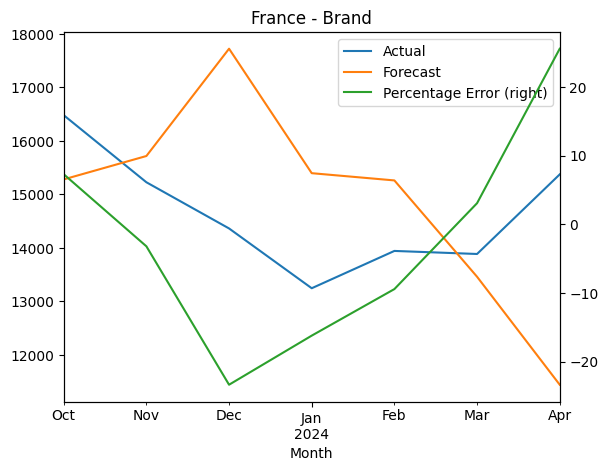

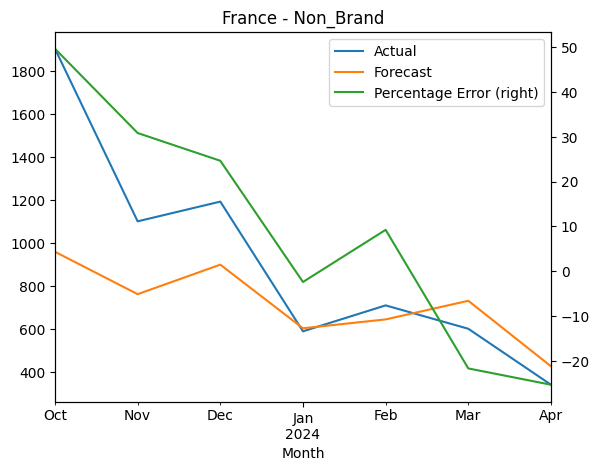

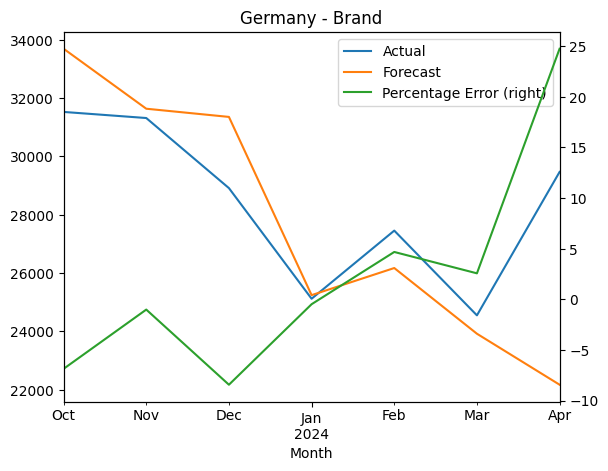

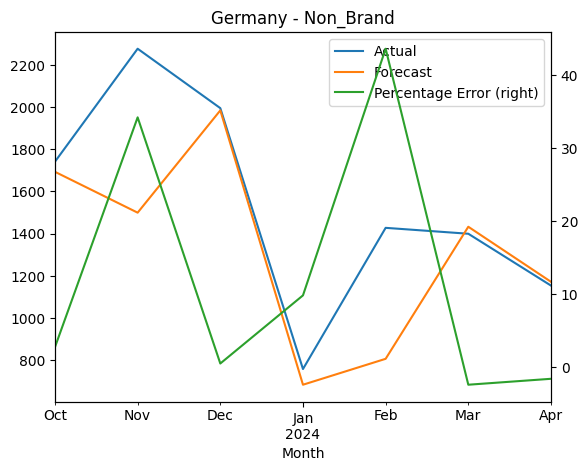

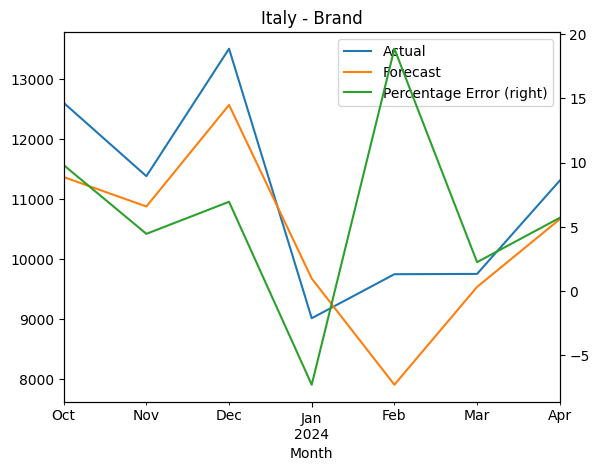

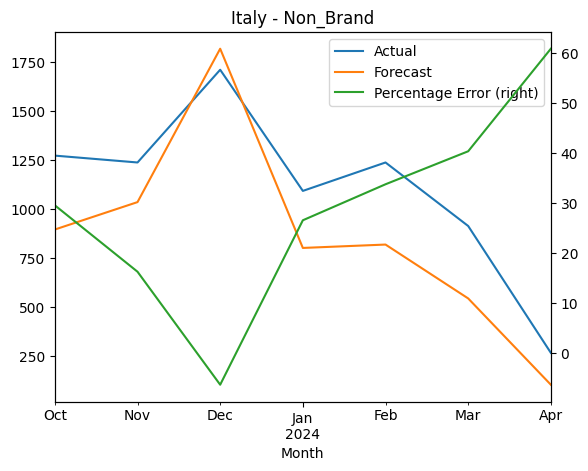

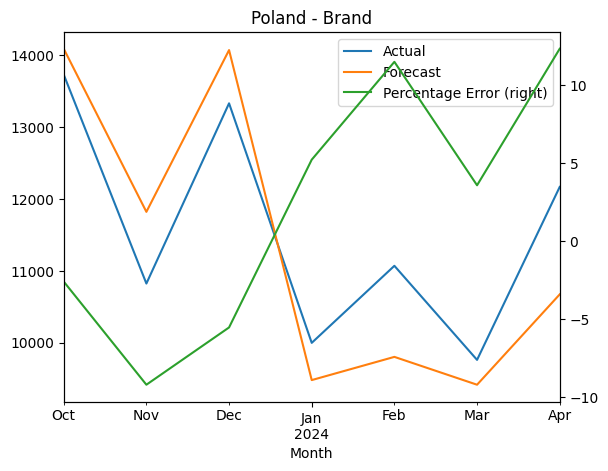

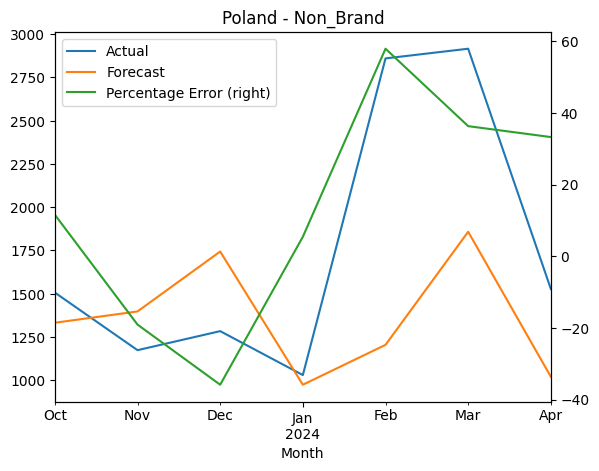

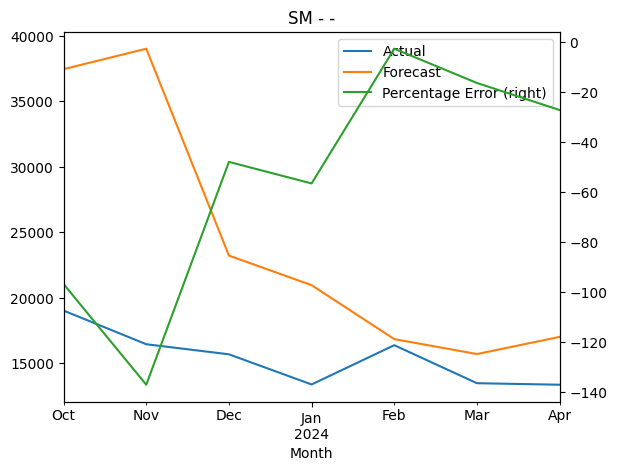

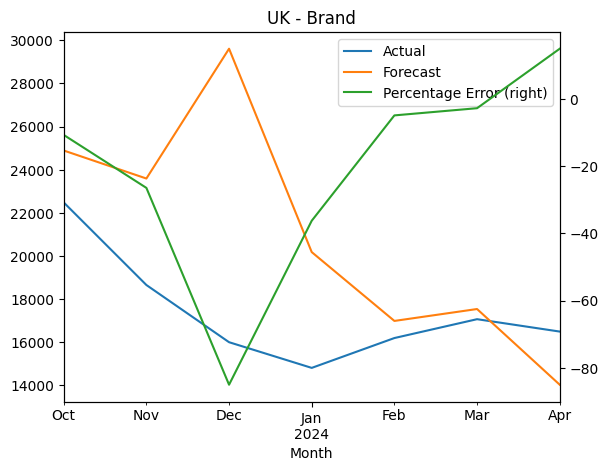

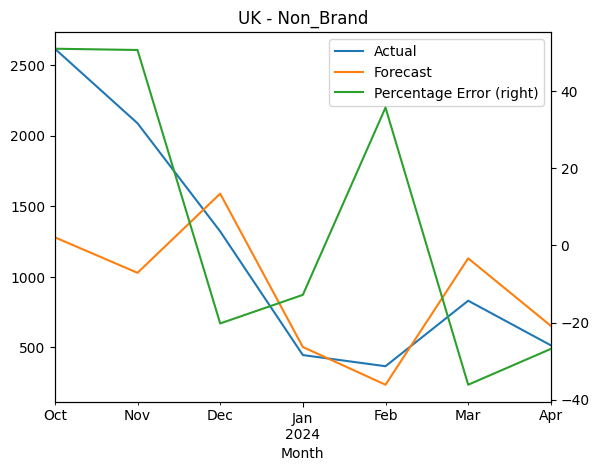

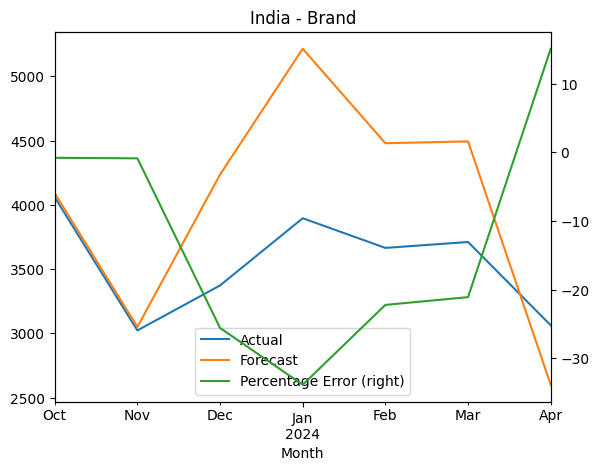

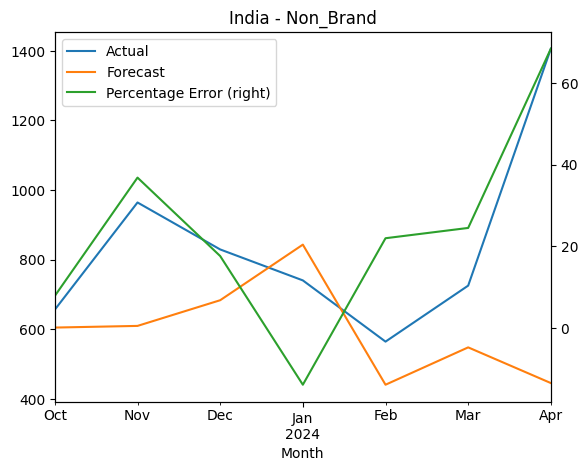

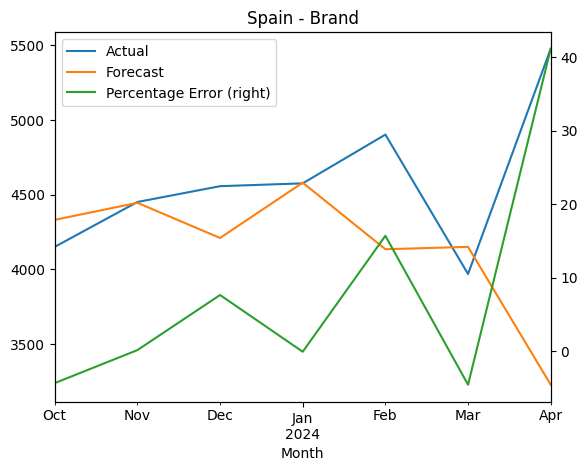

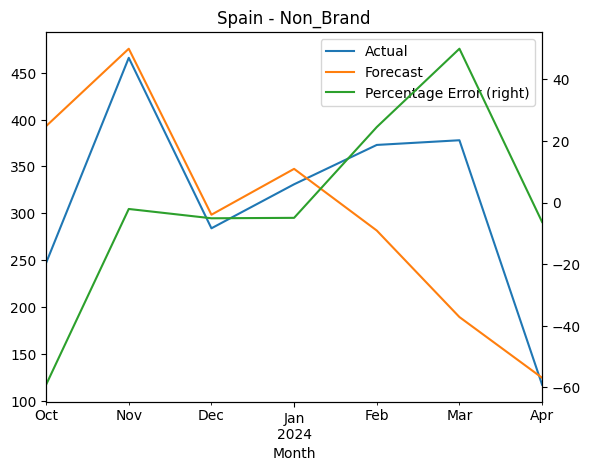

In [63]:
PlotAccuracyCharts(new_accuracy_df, New_Cuts_df, query_item_list)


## Trick
##### When accuracy is too lower for certain splits, consider the recent year trend change, instead of running training from the first day of the history, only use the recent years might be helpful. be cautious if using this methodology. Rows in df will need to be dropped before creating pickle files.
##### Below is an example for Google Competitor. Dropping the history data before Jan 1, 2022 will generate better accuracy.  

In [ ]:
# search_engine = ProphetParameterSearch(power_flag=False, base_path=base_path) # 
# # search_engine.add_power_params() # consider using it when the basic setting won't get you good results
# grid_brand = search_engine.search(cuts_df[cuts_df.index == 4], df[df.ds>="2022-01-01"]) 

In [ ]:
# modify and use the line below only if Trick is used
#df.drop(df[(df.account_type == 'Google AdWords') & (df.funnel == 'Competitor') & (df.ds <= '2022-01-01')].index, inplace=True)
#df.drop(df[(df.account_type == 'Bing Ads') & (df.funnel == 'Generic') & (df.ds <= '2022-01-01')].index, inplace=True)
#df = df[df.ds < cutoff_month].copy()
# df.to_csv(daily_df_out_path)

In [ ]:
# when accuracy is too lower for certain splits, consider the recent year trend change
# instead of running training from the first day of the history, only use the recent years might be helpful
# be cautious if using this methodolofy. rows in df will need to be dropped before creating pickle files
# example 
temp_df = df[(df.account_type == 'Google AdWords') & (df.funnel == 'Competitor') & (df.ds >= '2022-01-01')]
search_engine = ProphetParameterSearch(power_flag = False, base_path=base_path) #, linear_flag = False 
grid_brand = search_engine.search(cuts_df.iloc[[0],:], temp_df)

In [ ]:
# Code to save accuracy plot
# df_for_plt =  accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis = 1).pivot(index = 'Month', columns = (query_item_list), values = 'Percentage Error')

# plot_printer = PlotAndSaveAccuracyDf()
# fig = plot_printer.Plot(df_for_plt)
# plot_printer.SaveToGCS(bucket_name,  plot_name, folder_name)

In [ ]:
%load_ext autoreload
%autoreload 2
search_engine = ProphetParameterSearch(power_flag = False)# , logistic_flag = False
# search_engine.add_power_params()
grid_bing = search_engine.search(cuts_df[(cuts_df.index>=3)&(cuts_df.index<=4)], df)
# grid

  0%|          | 0/2 [00:00<?, ?it/s]

# Model Generator

Generate pickle files where are stored the prophet model trained with the selected hyper parameters, the training data set and the complete data set

In [21]:
# %load_ext autoreload
# %autoreload 
model_generator = GenerateModelFile()
model_generator.Generate(New_Cuts_df, final_df , query_item_list, output_bucket, folder_name, base_path=base_path)

21:08:42 - cmdstanpy - INFO - Chain [1] start processing
21:08:42 - cmdstanpy - INFO - Chain [1] done processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:44 - cmdstanpy - INFO - Chain [1] done processing
21:08:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:44 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:57 - cmdstanpy - INFO - Chain [1] start processing
21:09:01 - cmdstanpy - INFO - Chain [1] done processing
21:09:03 - cmdstanpy - INFO - Chain [1] start processing
21:09:03 - cmdstanpy - INFO - Chain [1] done processing
21:09:05 - cmdstanpy - INFO - Chain [1] start processing
21:09:05 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:11 - cmdstanpy - INFO - Chain [1] done processing
21:09:12 - cmdstanpy - INFO - Chain [1] start process

# Exam 

Exam the performance of 'US Bing Ads Generic' to understand the prediction trend since it is gettiong bad results

Import needed packages

In [24]:
import pickle
from repo.Accuracy import MakeFuture
from prophet.plot import plot_plotly, plot_components_plotly

Read the split pickle file 

In [25]:
# set the pickle file name 
file_name = "US Bing Ads Generic.pkl"
pickle_file_path = base_path + file_name

# open the pickle file 
pickle_in = open(pickle_file_path,'rb') 

# unpickled model is the model to use, training_dataset is used to get historical spend
unpickled_model, training_dataset, model_df = pickle.load(pickle_in)


Set a copy of the analytical file and some splits variables

In [26]:
analytical_file_copy = analytical_file_df.copy() # set the analytical file copy
market = 'US' # set the first split breakdown variable value
account_type = 'Bing Ads' # set the second split breakdown variable value
funnel = 'Generic' # set the third split breakdown variable value


Filter the analytical file for just the selected split

In [27]:
spend_df_for_forecast = analytical_file_copy[(analytical_file_copy['market'] == market) & (analytical_file_copy['account_type'] == account_type) & \
                                              (analytical_file_copy['funnel'] == funnel)].copy()

spend_df_for_forecast['ds'] = pd.to_datetime(spend_df_for_forecast.ds)

for i in New_Cuts_df.loc[(New_Cuts_df['market']=='US') & (New_Cuts_df['account_type']=='Bing Ads') & (New_Cuts_df['funnel']=='Generic')].itertuples(): # get the itertuple for 
     pass 


Create the future data frame and predict using the prophet model

In [28]:

# create the future data frame
future = MakeFuture(model = unpickled_model, model_df = training_dataset, values = i, periods = 183, future_input_df = spend_df_for_forecast)
forecast = unpickled_model.predict(future) # predict the model with the future data frame


Plot components of the prophet forecast and plot the forecast

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavio

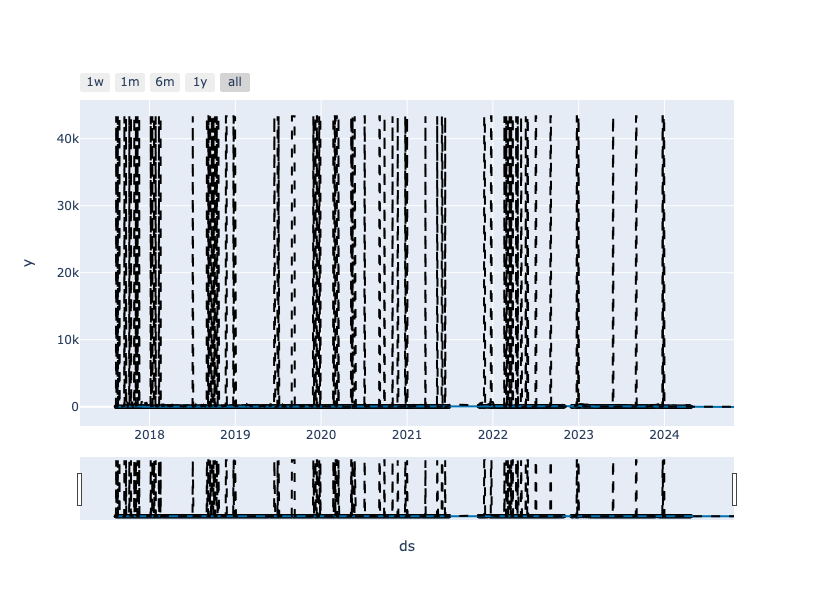

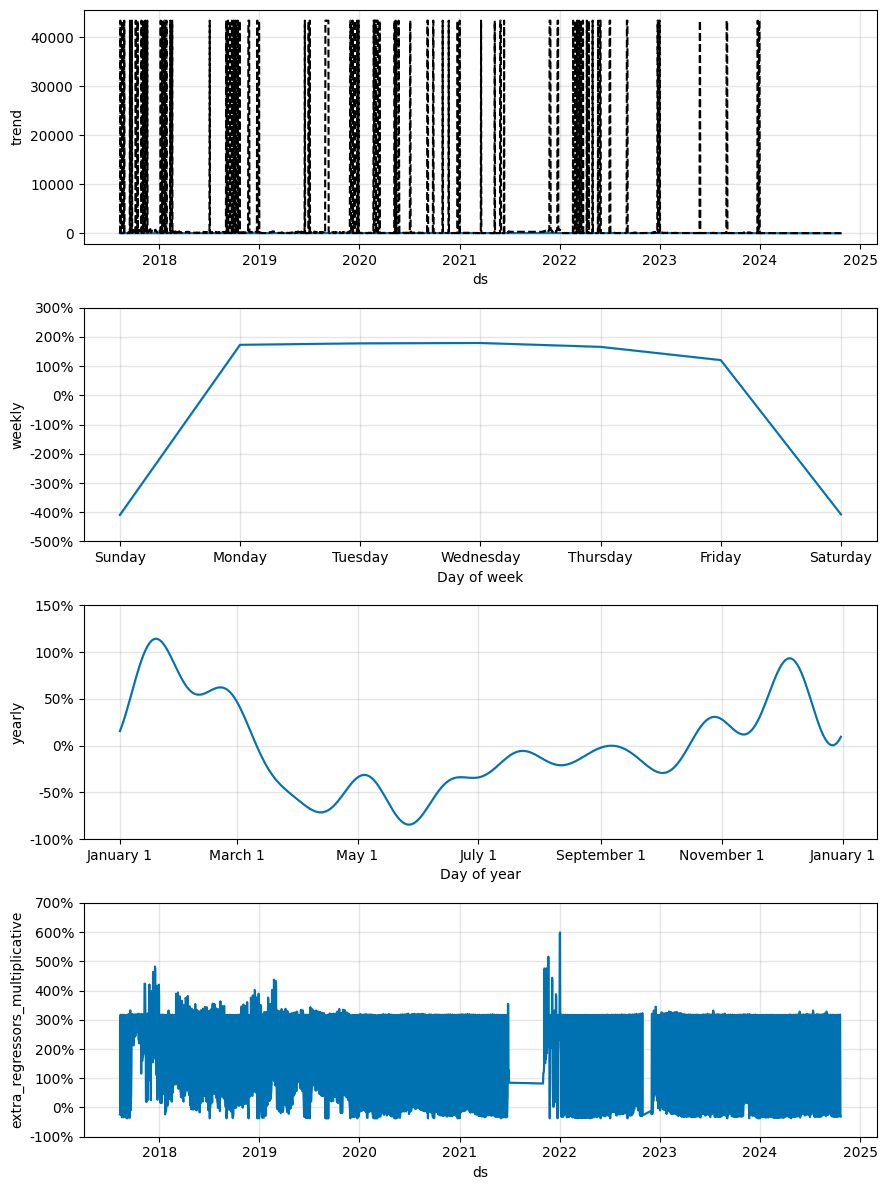

In [29]:
unpickled_model.plot_components(forecast) # plot components
plot_plotly(unpickled_model, forecast) # plot the forecast model

# Constraint Setting

In [22]:
bounds = New_Cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

# %load_ext autoreload
# %autoreload 2
constraint_file_generator = ConstraintFileGenerator(config_dict, analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds)
# constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)

### When constraints are customized

In [23]:
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MinWeight'] = 0.7
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MaxWeight'] = 0.8


In [24]:
constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name, df=constraint_file)

Data Frame file saved
